## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-06-13 13:16:12.820657


{1: 24.4,
 5: 25.6,
 10: 26.2,
 20: 27.1,
 30: 28.2,
 40: 29.8,
 50: 31.6,
 60: 33.3,
 70: 35.2,
 80: 37.5,
 90: 41.0,
 95: 43.8,
 99: 49.4}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-09-12 11:47:59.680802


{1: 8.3,
 5: 8.4,
 10: 8.5,
 20: 8.6,
 30: 8.8,
 40: 8.8,
 50: 8.9,
 60: 9.0,
 70: 9.2,
 80: 9.3,
 90: 9.5,
 95: 9.7,
 99: 10.1}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-06-13 20:05:32.824387


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)}}

In [6]:
def wildeford_max_gdp_frac():
    gdp_frac = sq.mixture([[0.9, sq.lognorm(1/500, 1/100)],
                           [0.1, sq.lognorm(1/100, 1/20)]])
    percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
    percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)
    compute_frac = gdp_frac * percent_spent_on_compute * percent_spent_on_largest_model
    return {'total_frac': gdp_frac, 'compute_frac': compute_frac}


base_flop_per_dollar = sq.lognorm(18.2, 19.4) # https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
# I'd use 1.43e18 FLOP/$ if renting cloud compute for training (significantly higher for serving a product, and significantly lower if using your own compute -- but then the number depends on how long you amortize it over).
# Source: If renting cloud compute, pricing seems to be $1.89-2.40 per H100 hour. (Jack Clark says $2 with bulk discounts.) Going with $2/hr, with the H100's 1.98e15 FLOP/s (FP8) and assuming 40% utilization (for training), that's 1.98e15*.4*60*60/2 = 1.43e18 FLOP/$.
# https://jack-clark.net/2024/03/28/what-does-1025-versus-1026-mean/ and https://gpus.llm-utils.org/h100-gpu-cloud-availability-and-pricing/
flop_frontier_penalty = sq.norm(0, 1)

# https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': np.array(tai_flop_size),
             'algo_doubling_rate_max': sq.lognorm(0.5, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': base_flop_per_dollar - flop_frontier_penalty,
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': np.array(initial_pay),
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'],
             'spend_doubling_time': sq.lognorm(0.5, 2, lclip=0.1),
             'nonscaling_delay': delay}

variables

{'initial_gdp': <Distribution> 23320000000000.0 * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) (version 0.28-dev3),
 'tai_flop_size': array([36.1, 34.8, 42.7, ..., 28.1, 31.4, 45.4]),
 'algo_doubling_rate_max': <Distribution> lognorm(lognorm_mean=1.42, lognorm_sd=0.83, norm_mean=0.2, norm_sd=0.54) (version 0.28-dev3),
 'algo_doubling_rate_min': <Distribution> lognorm(lognorm_mean=1.09, lognorm_sd=0.48, norm_mean=0.0, norm_sd=0.42) (version 0.28-dev3),
 'min_reduction': 2,
 'max_reduction': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev3),
 'initial_flop_per_dollar': <Distribution> lognorm(lognorm_mean=18.79, lognorm_sd=0.36, norm_mean=2.93, norm_sd=0.02) - norm(mean=0.5, sd=0.3) (version 0.28-dev3),
 'flop_halving_rate': <Distribution> norm(mean=2.5, sd=0.

## GDP Frac

### GDP

In [7]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000)
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '24.8 trillion',
 5: '24.9 trillion',
 10: '25.0 trillion',
 20: '25.0 trillion',
 30: '25.0 trillion',
 40: '25.1 trillion',
 50: '25.1 trillion',
 60: '25.1 trillion',
 70: '25.2 trillion',
 80: '25.2 trillion',
 90: '25.3 trillion',
 95: '25.3 trillion',
 99: '25.4 trillion'}

#### Total % of GDP spent on entire project

In [8]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 17269.32it/s]


{1: 0.00144,
 5: 0.0021,
 10: 0.00249,
 20: 0.0031,
 30: 0.00363,
 40: 0.00421,
 50: 0.0048,
 60: 0.0055,
 70: 0.00644,
 80: 0.00802,
 90: 0.01269,
 95: 0.02169,
 99: 0.04288}

In [9]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.144%',
 5: '0.21%',
 10: '0.249%',
 20: '0.31%',
 30: '0.363%',
 40: '0.421%',
 50: '0.48%',
 60: '0.55%',
 70: '0.644%',
 80: '0.802%',
 90: '1.269%',
 95: '2.169%',
 99: '4.288%'}

In [10]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '36.2 billion',
 5: '52.8 billion',
 10: '62.4 billion',
 20: '77.7 billion',
 30: '91.1 billion',
 40: '105.6 billion',
 50: '120.5 billion',
 60: '137.8 billion',
 70: '161.6 billion',
 80: '201.1 billion',
 90: '318.4 billion',
 95: '544.6 billion',
 99: '1.1 trillion'}

#### Total % of GDP spent on compute for largest model

In [11]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6156.46it/s]


{1: '0.001%',
 5: '0.003%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.027%',
 50: '0.04%',
 60: '0.059%',
 70: '0.088%',
 80: '0.142%',
 90: '0.264%',
 95: '0.42%',
 99: '1.137%'}

In [12]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.001%',
 5: '0.003%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.027%',
 50: '0.04%',
 60: '0.059%',
 70: '0.088%',
 80: '0.142%',
 90: '0.264%',
 95: '0.42%',
 99: '1.137%'}

In [13]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '317.5 million',
 5: '874.3 million',
 10: '1.5 billion',
 20: '2.8 billion',
 30: '4.5 billion',
 40: '6.9 billion',
 50: '10.1 billion',
 60: '14.8 billion',
 70: '22.2 billion',
 80: '35.7 billion',
 90: '66.6 billion',
 95: '105.4 billion',
 99: '283.8 billion'}

In [14]:
def model():
    frac = wildeford_max_gdp_frac()
    return frac['total_frac'] / frac['compute_frac']

sq.get_percentiles(sq.sample(model, verbose=True, n=5000), digits=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3636.79it/s]


{1: 0.4,
 5: 1.0,
 10: 1.7,
 20: 3.6,
 30: 6.0,
 40: 9.0,
 50: 13.4,
 60: 20.0,
 70: 31.5,
 80: 53.8,
 90: 114.7,
 95: 203.1,
 99: 708.2}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~873.3 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~964.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~626.4 million).
* This doubles every 1.3 year to a max of 0.339354% of GDP (initially ~86.3 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 34.0 logFLOP which costs 16.1 log 2025$USD to buy vs. WTP at 8.8 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 33.7 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 33.4 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 9.2 (buys 27.4 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 33.1 logFLOP which cost

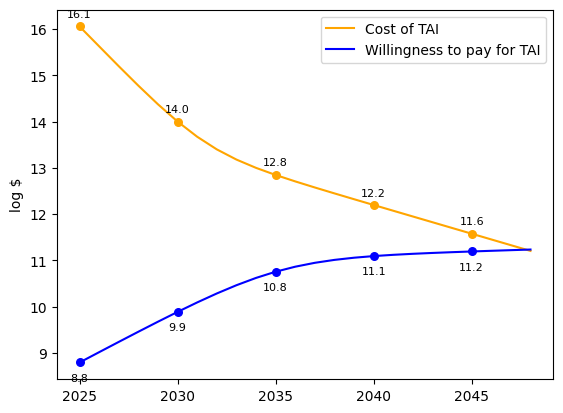



## SAMPLE RUN 2 ##

In this simulation:
* It takes 28.4 log FLOP (~25.1 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.7 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~81.2 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 1.4 year to a max of 0.167715% of GDP (initially ~42.1 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 28.4 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 28.1 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 9.4 (buys 28.5 log FLOP or 28.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 13 years (to

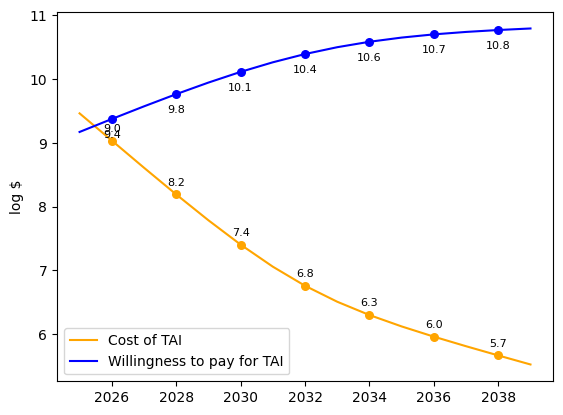



## SAMPLE RUN 3 ##

In this simulation:
* It takes 25.5 log FLOP (~31.6 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~739.6 quadrillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~1.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~972.9 million).
* This doubles every 0.6 year to a max of 0.142409% of GDP (initially ~35.9 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 25.5 logFLOP which costs 7.6 log 2025$USD to buy vs. WTP at 9.0 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 6 mo

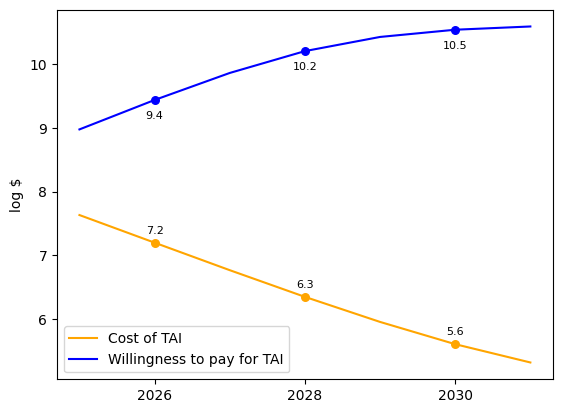



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:12, 778.87it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1449.81it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['1%: 2025',
 '2%: 2026',
 '3%: 2027',
 '4%: 2027',
 '5%: 2028',
 '10%: 2030',
 '15%: 2031',
 '20%: 2032',
 '25%: 2033',
 '35%: 2035',
 '50%: 2041',
 '60%: 2047',
 '75%: 2071',
 '80%: 2089',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['1%: 0 years from now',
 '2%: 1 years from now',
 '3%: 2 years from now',
 '4%: 2 years from now',
 '5%: 3 years from now',
 '10%: 5 years from now',
 '15%: 6 years from now',
 '20%: 7 years from now',
 '25%: 8 years from now',
 '35%: 10 years from now',
 '50%: 16 years from now',
 '60%: 22 years from now',
 '75%: 46 years from now',
 '80%: 64 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 33 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 2.3%
2027-2029: 5.9%
2030-2034: 24.0%
2035-2039: 16.



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~26.0 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.3 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.9 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.5 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.5 trillion) 80% CI 13.4 (~26.7 trillion) - 13.5 (~28.3 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.1 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.1 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.5 trillion) - 13.5 (~30.0 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.4 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.8 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.1 trillion) 80% CI 13.5 (~28.4 trillion) - 13.5 (~31.7 trillion)
Year: 2034 - GDP log 2024$USD 13.

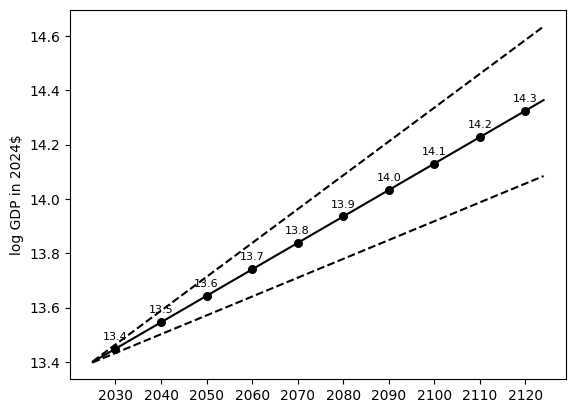

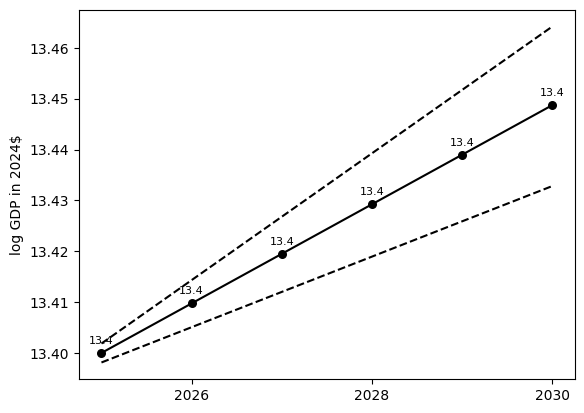



## Willingness to Pay Over Time (Total infrastructure) ##
Year: 2025 - willingness log 2024$USD per year for total infrastructure 10.3 (~18.3 billion) 80% CI 9.5 (~3.5 billion) - 11.2 (~150.5 billion)
Year: 2026 - willingness log 2024$USD per year for total infrastructure 10.5 (~34.4 billion) 80% CI 9.9 (~8.0 billion) - 11.4 (~239.1 billion)
Year: 2027 - willingness log 2024$USD per year for total infrastructure 10.8 (~61.1 billion) 80% CI 10.2 (~15.2 billion) - 11.6 (~373.0 billion)
Year: 2028 - willingness log 2024$USD per year for total infrastructure 11.0 (~99.6 billion) 80% CI 10.4 (~22.7 billion) - 11.8 (~567.4 billion)
Year: 2029 - willingness log 2024$USD per year for total infrastructure 11.2 (~145.8 billion) 80% CI 10.4 (~27.9 billion) - 11.9 (~833.8 billion)
Year: 2030 - willingness log 2024$USD per year for total infrastructure 11.3 (~190.9 billion) 80% CI 10.5 (~30.8 billion) - 12.1 (~1.2 trillion)
Year: 2031 - willingness log 2024$USD per year for total infrastructure 1

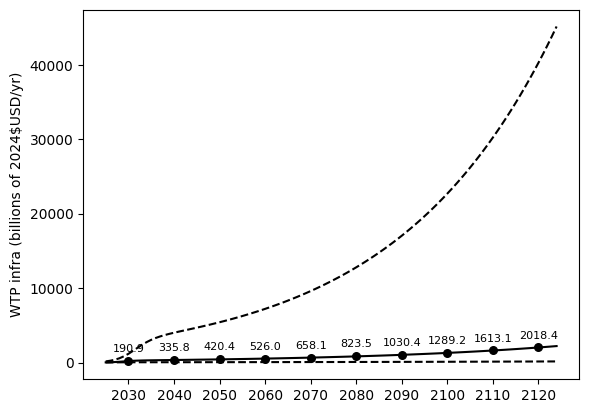

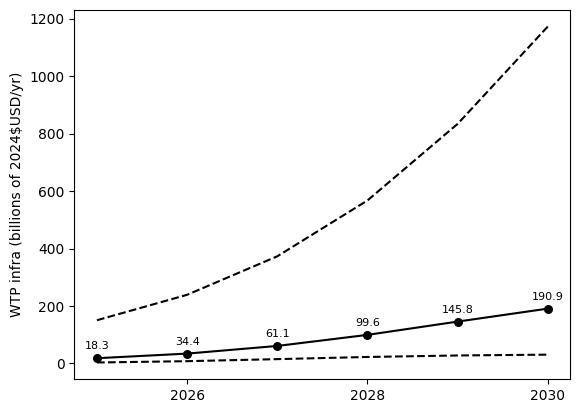



## Willingness to Pay Over Time (Largest single model) ##
Year: 2025 - willingness log 2024$USD per year for largest single model 8.9 (~733.6 million) 80% CI 8.5 (~351.3 million) - 9.3 (~1.9 billion)
Year: 2026 - willingness log 2024$USD per year for largest single model 9.1 (~1.4 billion) 80% CI 8.9 (~801.9 million) - 9.5 (~3.0 billion)
Year: 2027 - willingness log 2024$USD per year for largest single model 9.4 (~2.4 billion) 80% CI 9.2 (~1.5 billion) - 9.7 (~4.7 billion)
Year: 2028 - willingness log 2024$USD per year for largest single model 9.6 (~4.0 billion) 80% CI 9.4 (~2.3 billion) - 9.9 (~7.1 billion)
Year: 2029 - willingness log 2024$USD per year for largest single model 9.8 (~5.8 billion) 80% CI 9.4 (~2.8 billion) - 10.0 (~10.4 billion)
Year: 2030 - willingness log 2024$USD per year for largest single model 9.9 (~7.6 billion) 80% CI 9.5 (~3.1 billion) - 10.2 (~14.7 billion)
Year: 2031 - willingness log 2024$USD per year for largest single model 10.0 (~9.1 billion) 80% CI 9.5

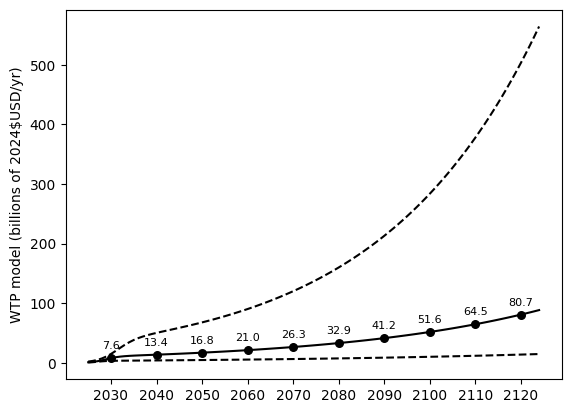

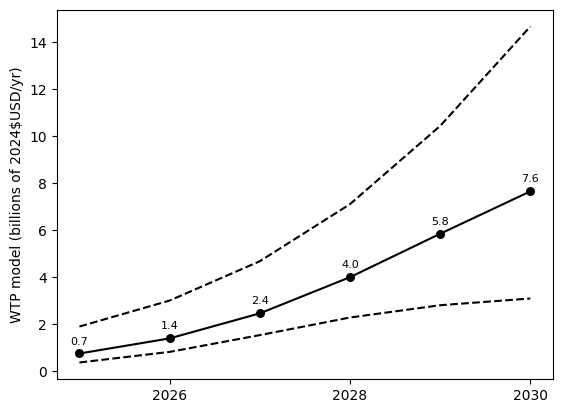



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 31.8 (~56.2 nonillion) 80% CI 27.1 (~1.3 octillion) - 37.3 (~20.0 thousand decillion)
Year: 2026 - logFLOP needed for TAI 31.5 (~29.0 nonillion) 80% CI 26.7 (~497.3 septillion) - 37.1 (~12.3 thousand decillion)
Year: 2027 - logFLOP needed for TAI 31.2 (~14.9 nonillion) 80% CI 26.3 (~199.2 septillion) - 36.9 (~7.6 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.9 (~7.8 nonillion) 80% CI 25.9 (~84.5 septillion) - 36.7 (~4.7 thousand decillion)
Year: 2029 - logFLOP needed for TAI 30.6 (~4.2 nonillion) 80% CI 25.6 (~40.3 septillion) - 36.5 (~2.9 thousand decillion)
Year: 2030 - logFLOP needed for TAI 30.4 (~2.4 nonillion) 80% CI 25.4 (~23.2 septillion) - 36.3 (~1.8 thousand decillion)
Year: 2031 - logFLOP needed for TAI 30.2 (~1.5 nonillion) 80% CI 25.2 (~16.7 septillion) - 36.1 (~1.1 thousand decillion)
Year: 2032 - logFLOP needed for TAI 30.0 (~1.0 nonillion) 80% CI 25.2 (~1

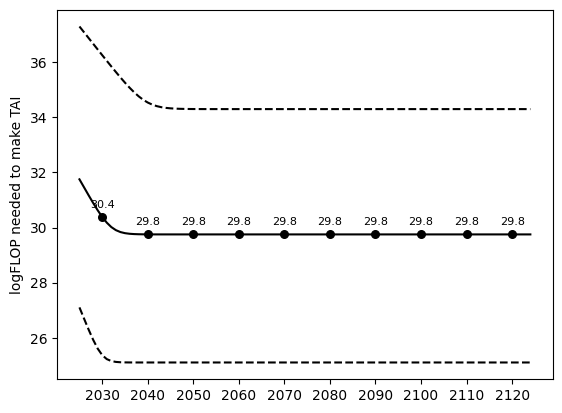

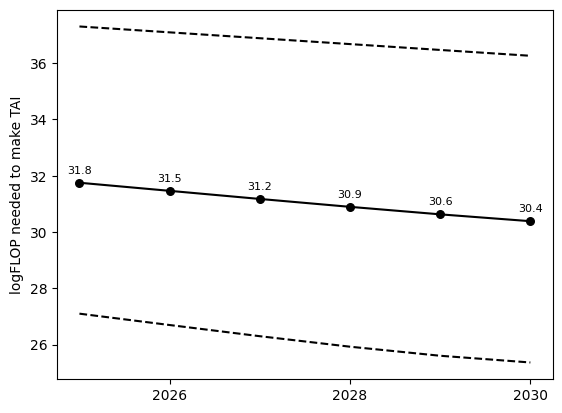



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.3 (~2.0 quintillion) 80% CI 17.9 (~838.6 quadrillion) - 18.7 (~5.1 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.4 (~2.7 quintillion) 80% CI 18.1 (~1.1 quintillion) - 18.8 (~6.5 quintillion)
Year: 2027 - logFLOP per 2024$1USD 18.5 (~3.5 quintillion) 80% CI 18.2 (~1.5 quintillion) - 18.9 (~8.4 quintillion)
Year: 2028 - logFLOP per 2024$1USD 18.7 (~4.6 quintillion) 80% CI 18.3 (~2.1 quintillion) - 19.0 (~10.8 quintillion)
Year: 2029 - logFLOP per 2024$1USD 18.8 (~6.1 quintillion) 80% CI 18.5 (~2.9 quintillion) - 19.1 (~13.9 quintillion)
Year: 2030 - logFLOP per 2024$1USD 18.9 (~8.1 quintillion) 80% CI 18.6 (~3.9 quintillion) - 19.3 (~17.8 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.0 (~10.7 quintillion) 80% CI 18.7 (~5.3 quintillion) - 19.4 (~22.9 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.1 (~14.1 quintillion) 80% CI 18.9 (~7.2 quintillion) - 19.5 (~29.5 quintillion)
Year: 2033 - lo

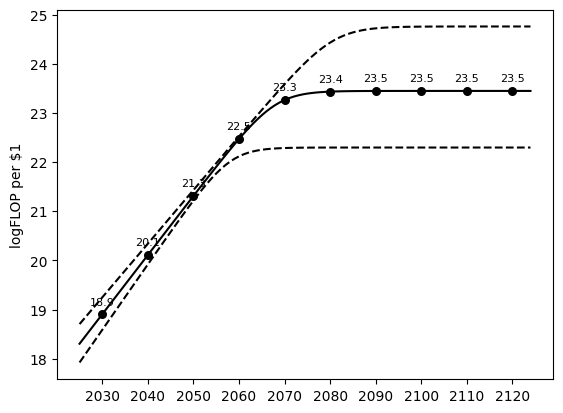

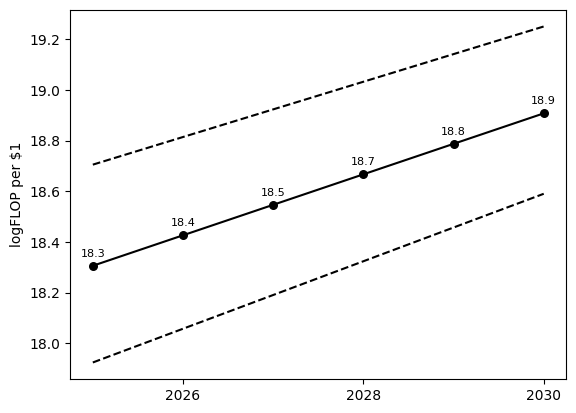



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

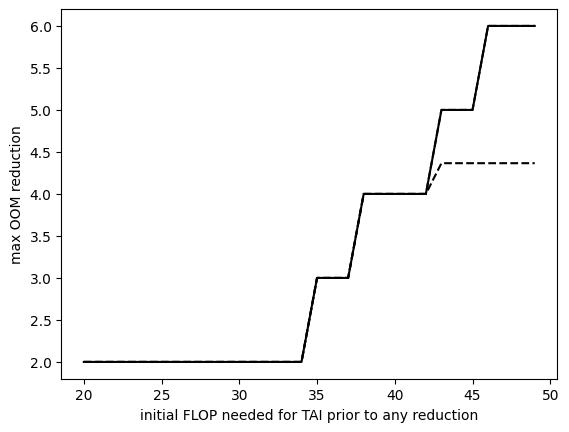



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 21 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 22 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 23 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 24 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 25 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 26 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 27 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 28 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 29 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 30 -> algo doubling rate 1.18yrs (80% CI: 1.81 to 1.81)
TAI log FLOP 31 -> algo doubling rate 1.02yrs (80% CI: 1.31 to 1.31)
TAI log FLOP 32 -> algo doubling rate 1.02yrs (80% CI: 0.81 to 0.81)
TAI log FLOP 33 -> algo doubling rate 1.02yrs (80%

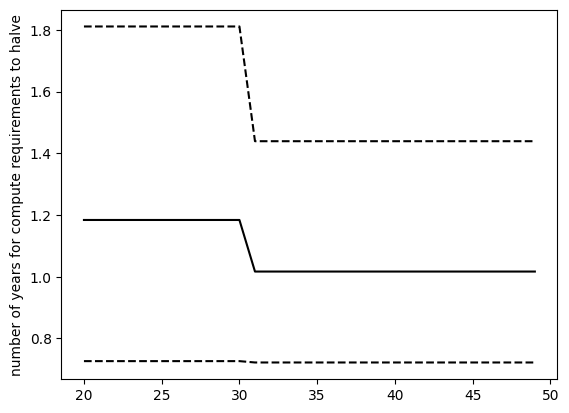



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 13.4 log 2024$USD to buy TAI (~27.8 trillion) 80% CI 9.2 (~1.5 billion) - 18.6 (~3.9 quintillion)
Year: 2026 - 13.0 log 2024$USD to buy TAI (~10.9 trillion) 80% CI 8.6 (~436.3 million) - 18.3 (~1.9 quintillion)
Year: 2027 - 12.6 log 2024$USD to buy TAI (~4.2 trillion) 80% CI 8.1 (~128.6 million) - 18.0 (~910.5 quadrillion)
Year: 2028 - 12.2 log 2024$USD to buy TAI (~1.7 trillion) 80% CI 7.6 (~40.1 million) - 17.6 (~438.2 quadrillion)
Year: 2029 - 11.8 log 2024$USD to buy TAI (~692.0 billion) 80% CI 7.1 (~14.1 million) - 17.3 (~211.1 quadrillion)
Year: 2030 - 11.5 log 2024$USD to buy TAI (~299.6 billion) 80% CI 6.8 (~6.0 million) - 17.0 (~101.9 quadrillion)
Year: 2031 - 11.1 log 2024$USD to buy TAI (~140.9 billion) 80% CI 6.5 (~3.2 million) - 16.7 (~49.3 quadrillion)
Year: 2032 - 10.9 log 2024$USD to buy TAI (~73.7 billion) 80% CI 6.3 (~2.0 million) - 16.4 (~23.9 quadrillion)
Year: 2

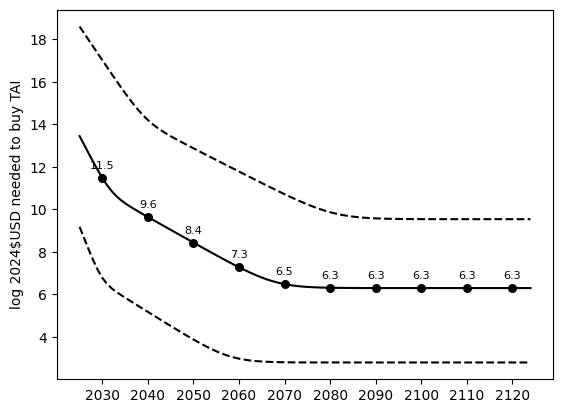

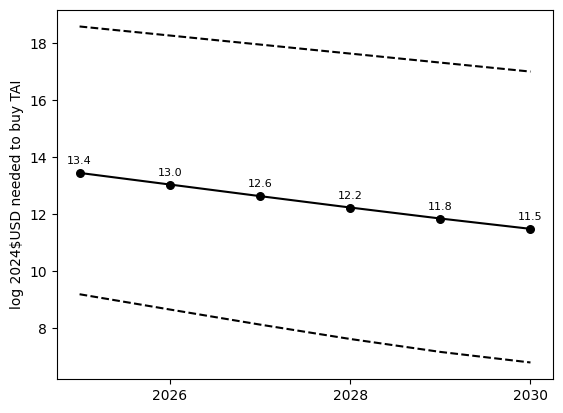



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.2 (~1.5 octillion) 80% CI 26.5 (~294.6 septillion) - 28.0 (~9.5 octillion)
Year: 2026 - max log FLOP 27.6 (~3.7 octillion) 80% CI 27.0 (~914.1 septillion) - 28.3 (~19.5 octillion)
Year: 2027 - max log FLOP 27.9 (~8.6 octillion) 80% CI 27.4 (~2.4 octillion) - 28.6 (~39.1 octillion)
Year: 2028 - max log FLOP 28.3 (~18.5 octillion) 80% CI 27.7 (~4.8 octillion) - 28.9 (~76.5 octillion)
Year: 2029 - max log FLOP 28.6 (~35.7 octillion) 80% CI 27.9 (~8.0 octillion) - 29.2 (~144.5 octillion)
Year: 2030 - max log FLOP 28.8 (~61.8 octillion) 80% CI 28.1 (~12.0 octillion) - 29.4 (~261.3 octillion)
Year: 2031 - max log FLOP 29.0 (~97.2 octillion) 80% CI 28.2 (~17.1 octillion) - 29.7 (~448.9 octillion)
Year: 2032 - max log FLOP 29.2 (~143.2 octillion) 80% CI 28.4 (~23.9 octillion) - 29.9 (~730.5 octillion)
Year: 2033 - max log FLOP 29.3 (~202.7 octillion) 80% CI 28.5 (~33.1 octillion) - 30.1 (~1.1 nonillion)
Year: 2034 - max log FLOP 29.

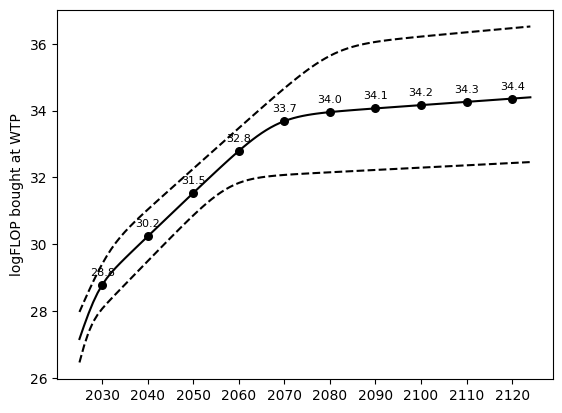

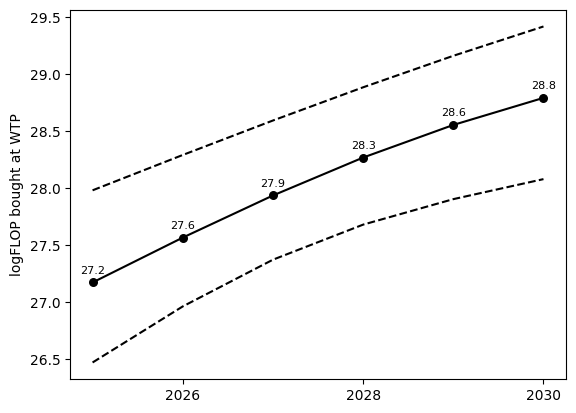



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.2 (~1.5 octillion) 80% CI 26.5 (~294.6 septillion) - 28.0 (~9.5 octillion)
Year: 2026 - max log effective 2024-FLOP 27.9 (~7.1 octillion) 80% CI 27.2 (~1.5 octillion) - 28.7 (~50.8 octillion)
Year: 2027 - max log effective 2024-FLOP 28.5 (~32.3 octillion) 80% CI 27.8 (~6.0 octillion) - 29.4 (~265.0 octillion)
Year: 2028 - max log effective 2024-FLOP 29.1 (~132.8 octillion) 80% CI 28.3 (~19.4 octillion) - 30.1 (~1.3 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.7 (~474.0 octillion) 80% CI 28.7 (~51.3 octillion) - 30.8 (~6.4 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.2 (~1.4 nonillion) 80% CI 29.1 (~119.7 octillion) - 31.5 (~28.3 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.6 (~3.6 nonillion) 80% CI 29.4 (~260.1 octillion) - 32.0 (~108.2 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~7.8 nonillion) 80% CI 29.7 (

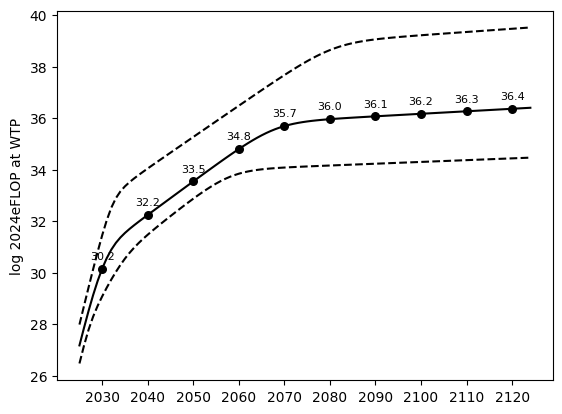

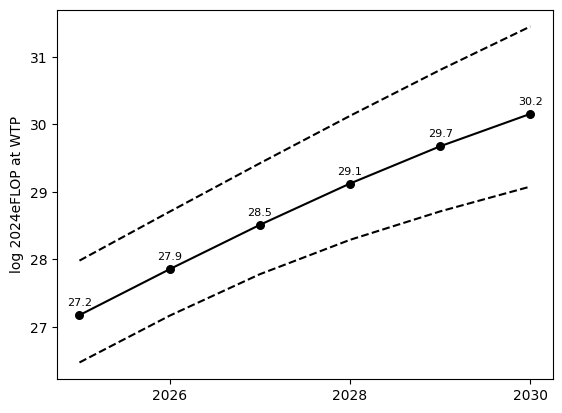


## TAI FLOP SIZE ##
{1: 24.3,
 5: 25.6,
 10: 26.1,
 20: 27.1,
 30: 28.1,
 40: 30.060000000000002,
 50: 31.75,
 60: 33.5,
 70: 35.3,
 80: 37.3,
 90: 41.4,
 95: 44.90999999999999,
 99: 49.901999999999994}


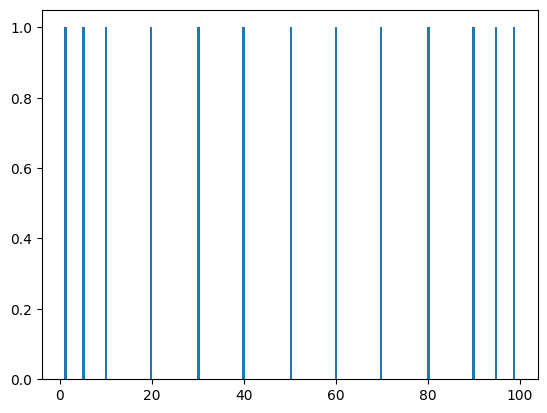



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.016492525635293,
 5: 2.9119499010856225,
 10: 3.508162177139926,
 20: 4.365756382136673,
 30: 5.253361991005479,
 40: 6.0170867696919235,
 50: 6.72238275732004,
 60: 7.504184827392157,
 70: 8.52053569547264,
 80: 10.097166763715583,
 90: 12.36134140193929,
 95: 14.673128181692563,
 99: 19.485099113617924}


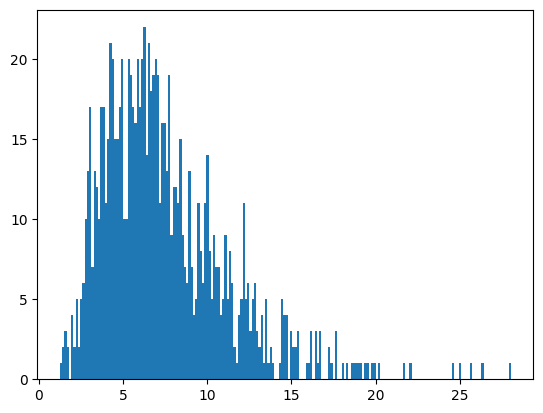



## MIN ALGO DOUBLING RATE ##
{1: 0.37490434087152186,
 5: 0.5153375615747912,
 10: 0.604186523301976,
 20: 0.7219121476912916,
 30: 0.8219473211107098,
 40: 0.9171188686200706,
 50: 1.0167497004995332,
 60: 1.11633368318342,
 70: 1.2513421077842364,
 80: 1.4393634072388075,
 90: 1.7288128662197113,
 95: 2.000822613850791,
 99: 3.0159863086505414}


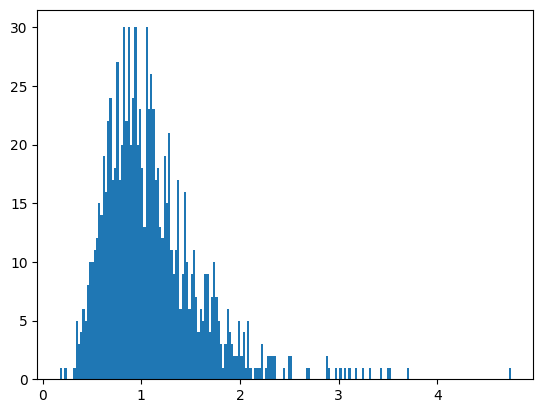



## MAX ALGO DOUBLING RATE ##
{1: 0.34053984406624255,
 5: 0.4567930964843077,
 10: 0.5630936496592717,
 20: 0.7262942525579914,
 30: 0.8990692211478882,
 40: 1.041741379229951,
 50: 1.1839668330684465,
 60: 1.3478370102324717,
 70: 1.5644684961127553,
 80: 1.8113704792498952,
 90: 2.392617553414495,
 95: 3.0395503246261066,
 99: 4.669976261942961}


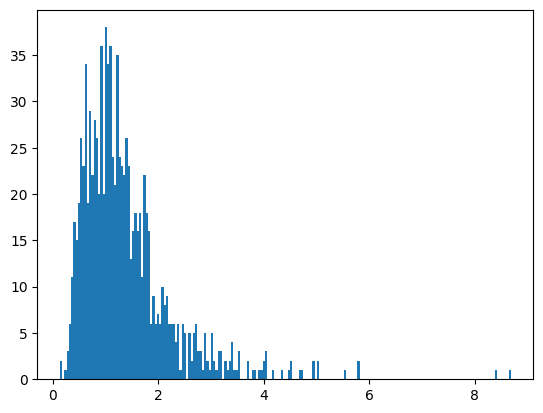



## INITIAL FLOP PER DOLLAR ##
{1: 17.235147422473666,
 5: 17.58110556383282,
 10: 17.723199044241802,
 20: 17.923598707460002,
 30: 18.075415826871062,
 40: 18.189361800056748,
 50: 18.305658958808138,
 60: 18.42358740012582,
 70: 18.558849607376825,
 80: 18.705214001490493,
 90: 18.90242869275938,
 95: 19.084487497044744,
 99: 19.385038748761843}


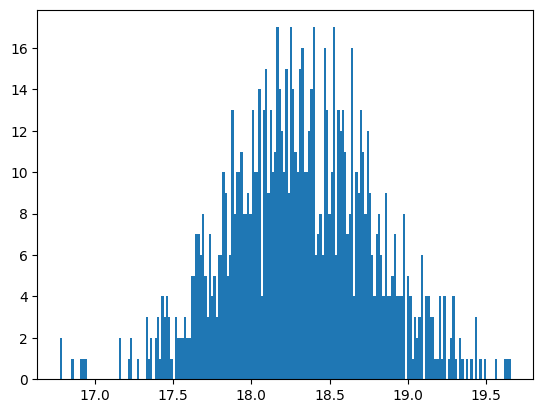



## FLOP HALVING RATE ##
{1: 1.81649214982143,
 5: 1.989355634470984,
 10: 2.1149592698654964,
 20: 2.25804195767912,
 30: 2.3428084871257906,
 40: 2.430017342879716,
 50: 2.499461891557402,
 60: 2.5815092155139867,
 70: 2.652419041296026,
 80: 2.7573977749084464,
 90: 2.912594651374296,
 95: 3.0272569564754575,
 99: 3.248303997991002}


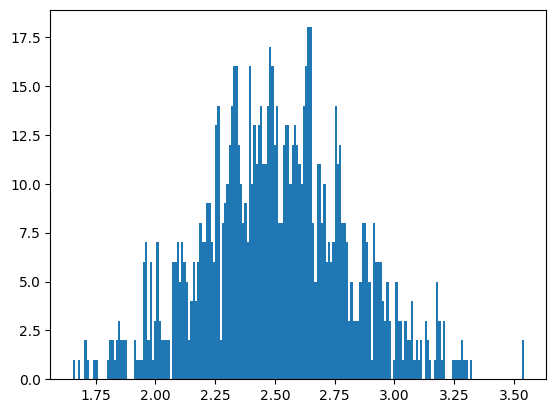



## MAX FLOP PER DOLLAR ##
{1: 19.83606270204478,
 5: 21.115869559351385,
 10: 21.70327964206366,
 20: 22.299502592829736,
 30: 22.736588389254983,
 40: 23.097550119219783,
 50: 23.451686492523784,
 60: 23.867199455652532,
 70: 24.2869912824975,
 80: 24.763752698452567,
 90: 25.33986576554617,
 95: 25.930883547477542,
 99: 26.964830517182623}


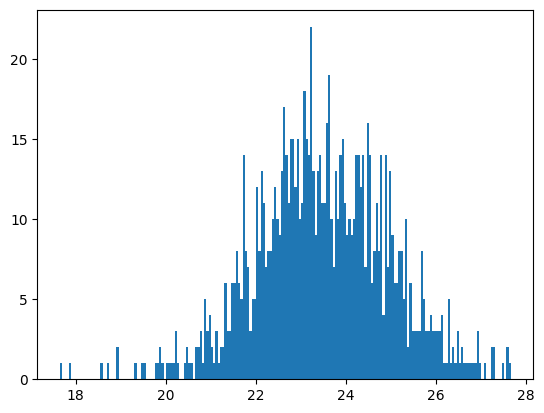



## INITIAL PAY ##
{1: 8.3,
 5: 8.4,
 10: 8.5,
 20: 8.6,
 30: 8.8,
 40: 8.9,
 50: 8.9,
 60: 9.1,
 70: 9.2,
 80: 9.3,
 90: 9.5,
 95: 9.7,
 99: 10.2}


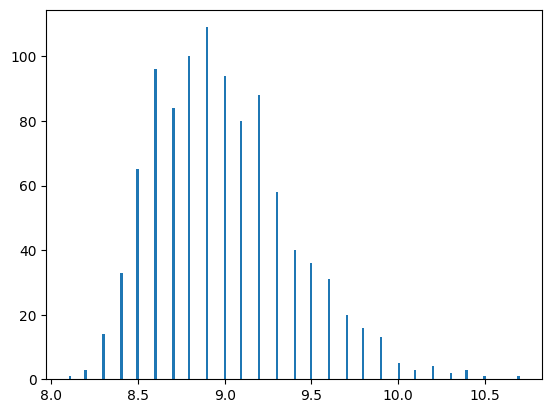



## INITIAL GDP ##
{1: 24805344851436.21,
 5: 24895852256411.89,
 10: 24950211806686.098,
 20: 25013933315098.336,
 30: 25056588912554.074,
 40: 25087615939401.895,
 50: 25121819089667.77,
 60: 25156297128470.79,
 70: 25191279630273.492,
 80: 25229303110123.547,
 90: 25285943435041.96,
 95: 25328305283632.77,
 99: 25463328714071.08}


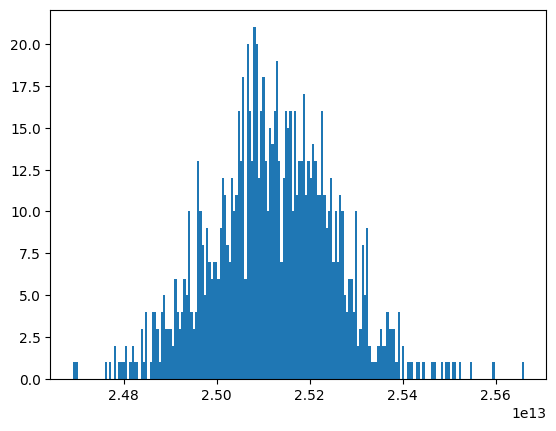



## GDP GROWTH ##
{1: 1.005,
 5: 1.0095277085473384,
 10: 1.0127132169303823,
 20: 1.01608534158045,
 30: 1.0186114152550039,
 40: 1.020536462159826,
 50: 1.0226655799069855,
 60: 1.0244129061366827,
 70: 1.026588943346059,
 80: 1.0290863375518782,
 90: 1.0324197534619064,
 95: 1.035469013152941,
 99: 1.0407971241306917}


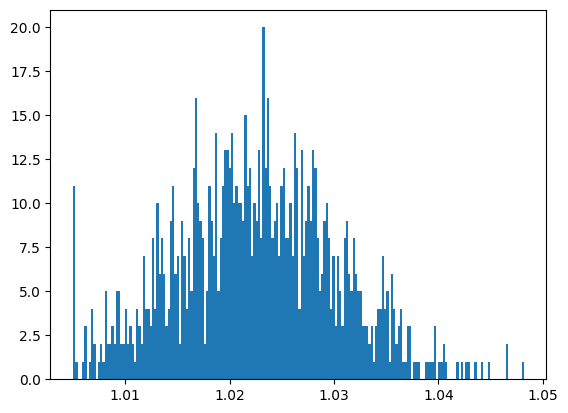



## MAX GDP FRAC ##
{1: 1.1228437360290858e-05,
 5: 4.0839762746632923e-05,
 10: 6.901617167386438e-05,
 20: 0.00011953773105491858,
 30: 0.00017819521893978625,
 40: 0.0002519823274482575,
 50: 0.00038221971149665147,
 60: 0.0005402360154316797,
 70: 0.00079715800421205,
 80: 0.0013091416684129136,
 90: 0.0027103813555173916,
 95: 0.004691324042864123,
 99: 0.009587671951702546}


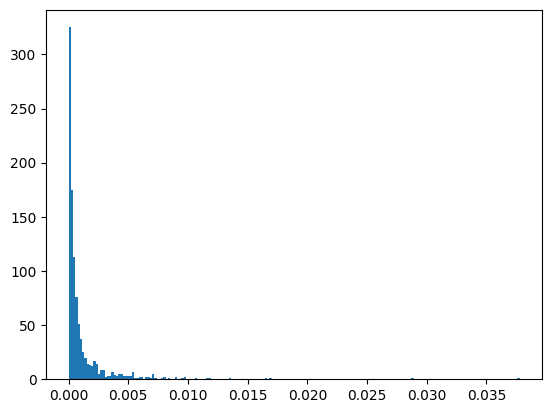



## SPEND DOUBLING TIME ##
{1: 0.3734311348865851,
 5: 0.4983875153724352,
 10: 0.5782417682186816,
 20: 0.6885123743113818,
 30: 0.8003957993224141,
 40: 0.8946337976082628,
 50: 0.9888008924193825,
 60: 1.1035451157169245,
 70: 1.2419159172142324,
 80: 1.3977549854491387,
 90: 1.6499698974202983,
 95: 1.9507051860682134,
 99: 2.569034039885672}


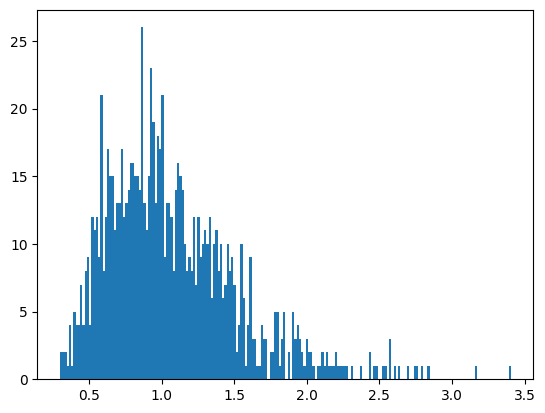





## Nonscaling delay ##
There are 3 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 1,
 5: 1,
 10: 1,
 20: 1,
 30: 2,
 40: 2,
 50: 2,
 60: 3,
 70: 3,
 80: 4,
 90: 5,
 95: 7,
 99: 18}
## Chance of nonscaling delay ##


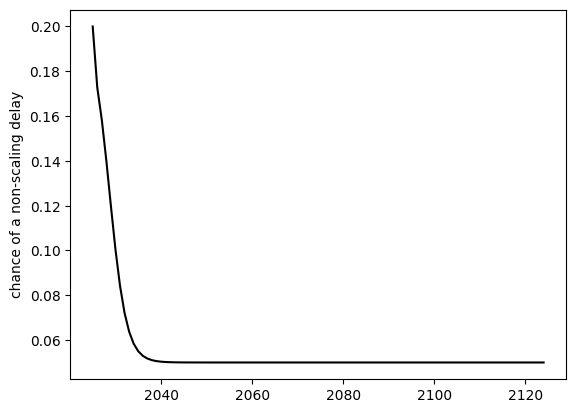

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2035 - c

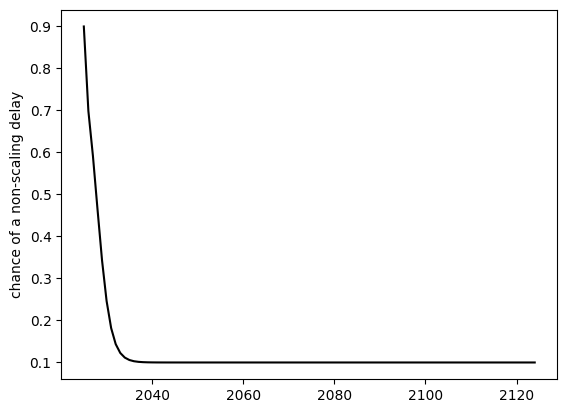

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2035

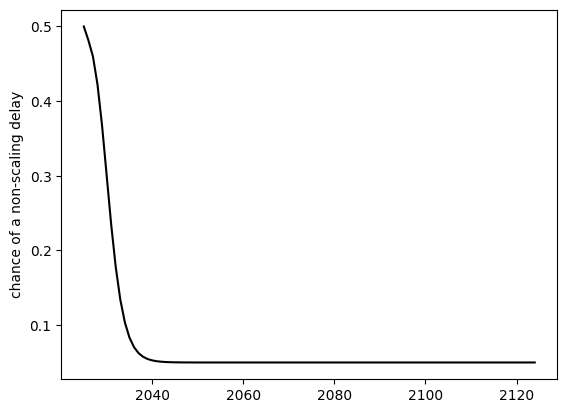

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 46%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

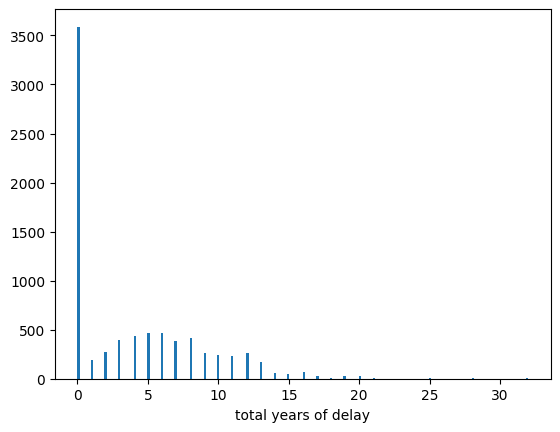

In [15]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 26.9 log FLOP (~794.3 septillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~341.0 million).
* This doubles every 1.4 year to a max of 0.009479% of GDP (initially ~2.4 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 26.9 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.5 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 26.6 logFLOP which costs 8.1 log 2025$USD to buy vs. WTP at 8.7 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 7 years

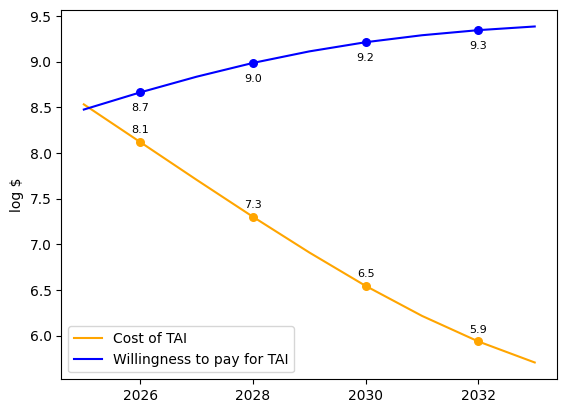

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 44.2 log FLOP (~158.5 billion decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 4.8 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.5 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~92.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~349.6 million).
* This doubles every 1.5 year to a max of 0.011417% of GDP (initially ~2.9 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 44.2 logFLOP which costs 25.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 43.7 logFLOP which costs 24.9 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 43.3 logFLOP which costs 24.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 42.8 logFLOP w

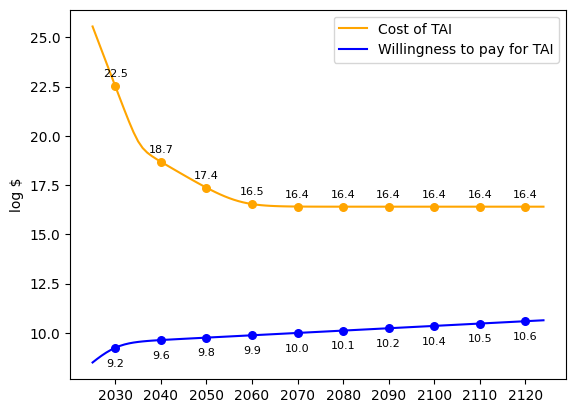

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 47.2 log FLOP (~158.5 trillion decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 6 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~687.3 quadrillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~77.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.0 year to a max of 0.018354% of GDP (initially ~4.6 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 47.2 logFLOP which costs 29.4 log 2025$USD to buy vs. WTP at 9.0 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 46.8 logFLOP which costs 28.8 log 2025$USD to buy vs. WTP at 9.2 (buys 27.2 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 46.3 logFLOP which costs 28.2 log 2025$USD to buy vs. WTP at 9.4 (buys 27.5 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 45.9 logFLOP wh

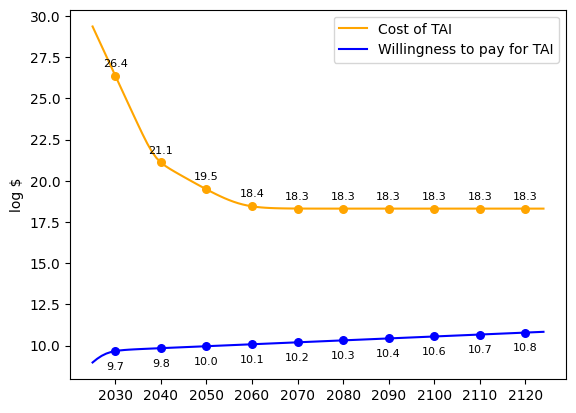

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 33.4 log FLOP (~2.5 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.5 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~738.3 million).
* This doubles every 0.9 year to a max of 0.041641% of GDP (initially ~10.5 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 33.4 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 8.8 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 33.1 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 32.8 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 9.4 (buys 28.0 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 32.5 logFLOP which costs 1

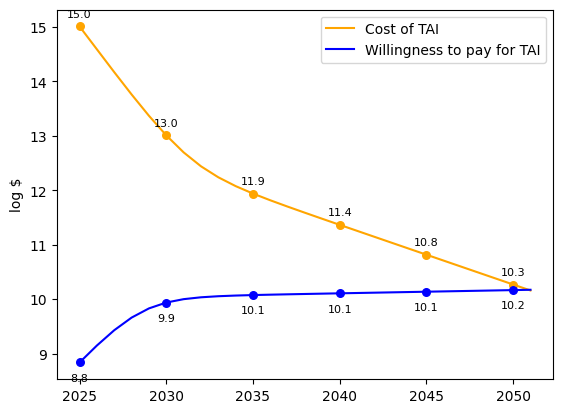

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.7 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~241.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~2.9 billion).
* This doubles every 0.9 year to a max of 0.136687% of GDP (initially ~34.5 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 18.3 log 2025$USD to buy vs. WTP at 9.4 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 36.4 logFLOP which costs 17.6 log 2025$USD to buy vs. WTP at 9.7 (buys 28.5 log FLOP or 29.2 2025-log-eFLOP)
2027 - TAI takes 35.7 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 10.0 (buys 28.9 log FLOP or 30.2 2025-log-eFLOP)
2028 - TAI takes 35.1 logFLOP whi

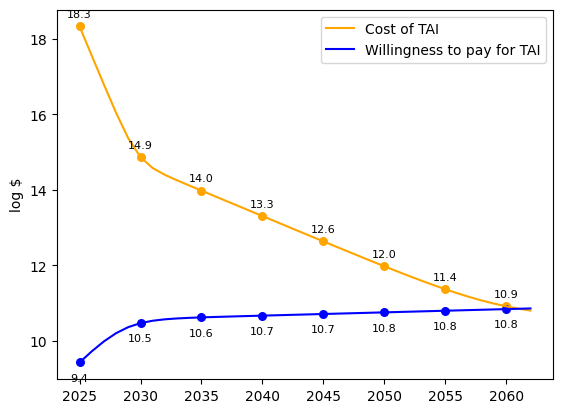

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~813.2 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~13.2 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~468.9 million).
* This doubles every 1.0 year to a max of 0.028845% of GDP (initially ~7.3 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 8.6 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 26.9 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 3 years 

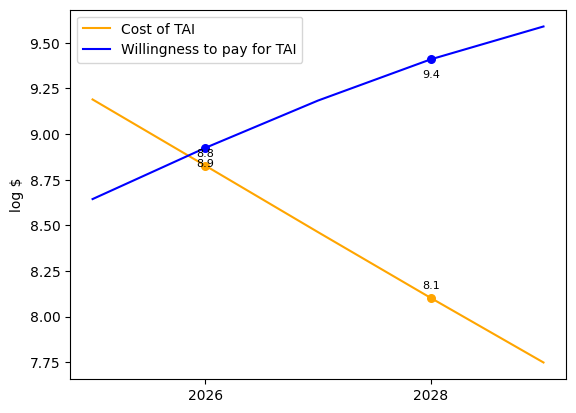

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 31.6 log FLOP (~39.8 nonillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~539.4 quadrillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~308.1 million).
* This doubles every 0.4 year to a max of 0.047798% of GDP (initially ~12.0 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 31.6 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 8.5 (buys 26.2 log FLOP or 26.2 2025-log-eFLOP)
2026 - TAI takes 31.2 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.0 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 30.7 logFLOP which costs 12.7 log 2025$USD to buy vs. WTP at 9.7 (buys 27.7 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 30.4 logFLOP which cos

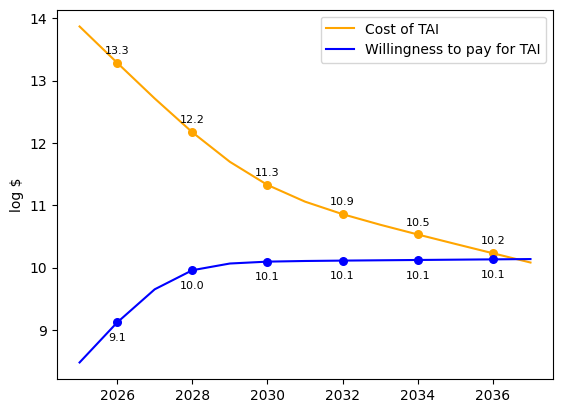

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 41.4 log FLOP (~251.2 million decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.6 billion).
* This doubles every 1.1 year to a max of 0.034566% of GDP (initially ~8.6 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 41.4 logFLOP which costs 23.2 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 41.1 logFLOP which costs 22.7 log 2025$USD to buy vs. WTP at 9.4 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 40.7 logFLOP which costs 22.3 log 2025$USD to buy vs. WTP at 9.5 (buys 28.0 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 40.4 logFLOP which

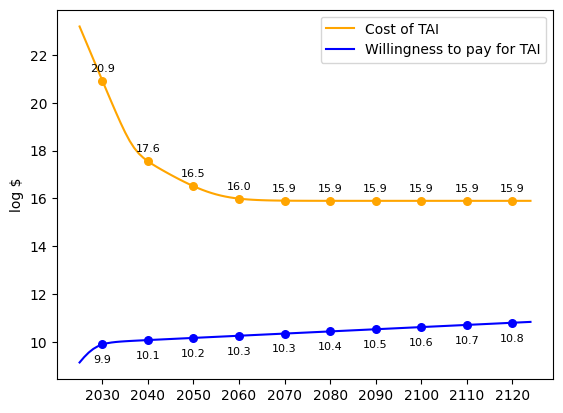

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 38.4 log FLOP (~251.2 thousand decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 3.7 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.5 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~985.5 million).
* This doubles every 0.8 year to a max of 0.271542% of GDP (initially ~67.7 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 38.4 logFLOP which costs 20.2 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 37.8 logFLOP which costs 19.4 log 2025$USD to buy vs. WTP at 9.4 (buys 27.7 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 37.1 logFLOP which costs 18.7 log 2025$USD to buy vs. WTP at 9.7 (buys 28.2 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 36.5 logFLOP

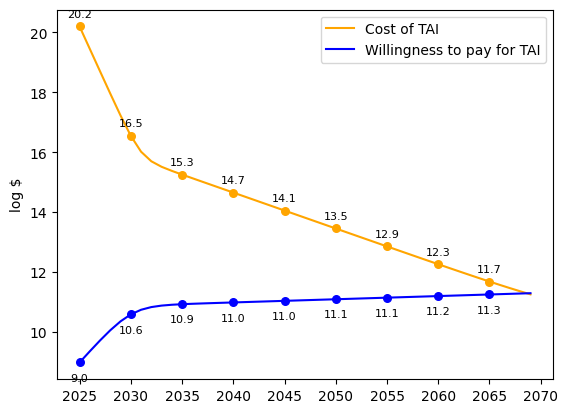

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 31.8 log FLOP (~63.1 nonillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~64.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~440.1 million).
* This doubles every 0.9 year to a max of 0.014386% of GDP (initially ~3.6 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 31.8 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 8.6 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 31.5 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 31.3 logFLOP which costs 12.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.7 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 31.0 logFLOP which costs

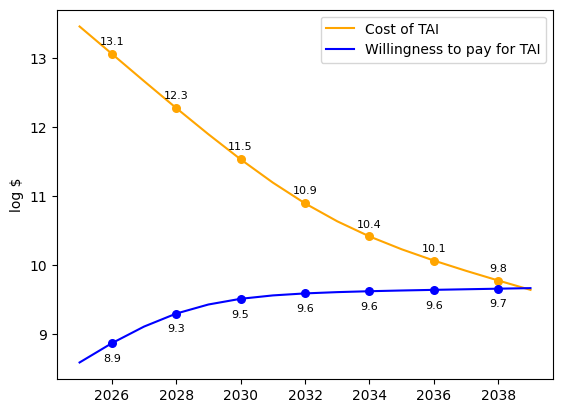

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 28.0 log FLOP (~10.0 octillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~293.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.6 billion).
* This doubles every 1.2 year to a max of 0.028901% of GDP (initially ~7.3 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 28.0 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 27.8 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 9.5 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 27.7 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.6 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 -> 

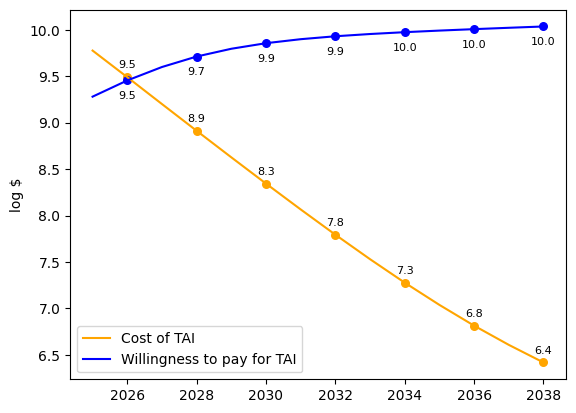

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 2.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~634.9 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~784.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~425.7 million).
* This doubles every 2.1 year to a max of 0.011295% of GDP (initially ~2.8 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.6 (buys 26.4 log FLOP or 26.4 2025-log-eFLOP)
2026 - TAI takes 26.5 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.7 (buys 26.6 log FLOP or 26.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 9 y

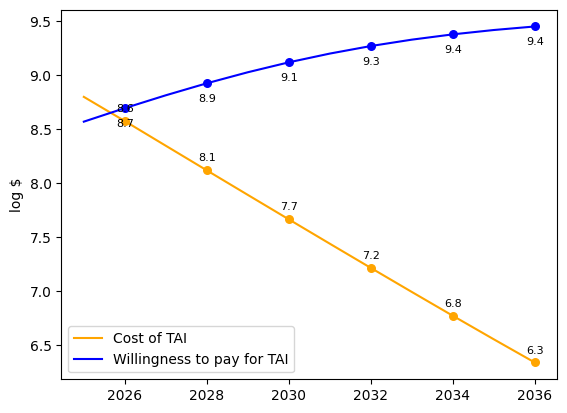

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 30.5 log FLOP (~3.2 nonillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~528.4 quadrillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~46.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~315.8 million).
* This doubles every 0.6 year to a max of 0.85642% of GDP (initially ~216.2 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 30.5 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 8.5 (buys 26.2 log FLOP or 26.2 2025-log-eFLOP)
2026 - TAI takes 30.3 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 9.0 (buys 26.8 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 30.1 logFLOP which costs 12.1 log 2025$USD to buy vs. WTP at 9.4 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 29.9 logFLOP which cos

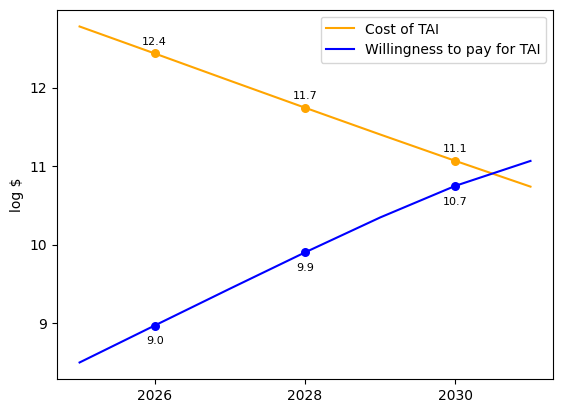

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 26.2 log FLOP (~158.5 septillion) for transformative capabilities.
* Every 3.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~169.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~390.3 million).
* This doubles every 0.7 year to a max of 0.079244% of GDP (initially ~19.8 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 26.2 logFLOP which costs 8.1 log 2025$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 7 y

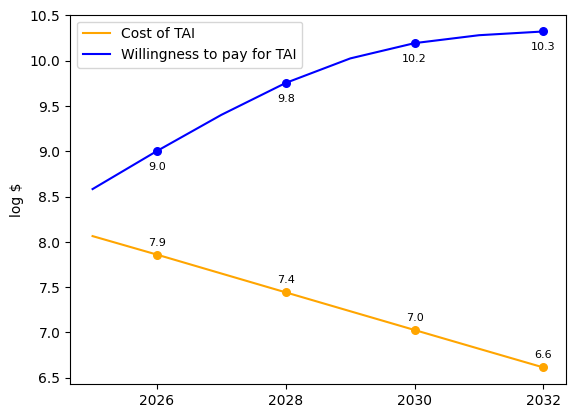

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.2 log FLOP (~168.1 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~360.4 million).
* This doubles every 1.5 year to a max of 0.015074% of GDP (initially ~3.8 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 19.8 log 2025$USD to buy vs. WTP at 8.5 (buys 25.7 log FLOP or 25.7 2025-log-eFLOP)
2026 - TAI takes 36.6 logFLOP which costs 19.2 log 2025$USD to buy vs. WTP at 8.7 (buys 26.0 log FLOP or 26.4 2025-log-eFLOP)
2027 - TAI takes 36.2 logFLOP which costs 18.7 log 2025$USD to buy vs. WTP at 8.9 (buys 26.3 log FLOP or 27.1 2025-log-eFLOP)
2028 - TAI takes 35.8 logFLOP w

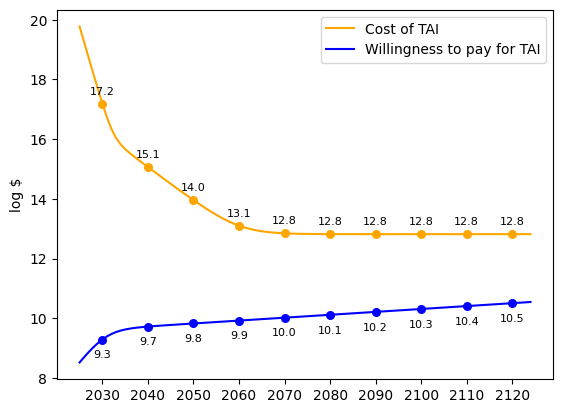

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 43.1 log FLOP (~12.6 billion decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~127.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~770.1 million).
* This doubles every 1.1 year to a max of 0.013445% of GDP (initially ~3.4 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 43.1 logFLOP which costs 24.8 log 2025$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 42.9 logFLOP which costs 24.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 42.8 logFLOP which costs 24.2 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 42.6 logFLOP wh

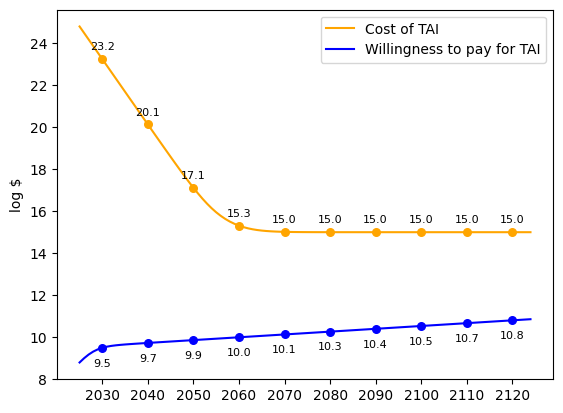

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 28.2 log FLOP (~15.8 octillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~11.4 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~497.3 million).
* This doubles every 0.7 year to a max of 0.257435% of GDP (initially ~64.9 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 28.2 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 8.7 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 28.0 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 27.8 logFLOP which costs 9.3 log 2025$USD to buy vs. WTP at 9.6 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 

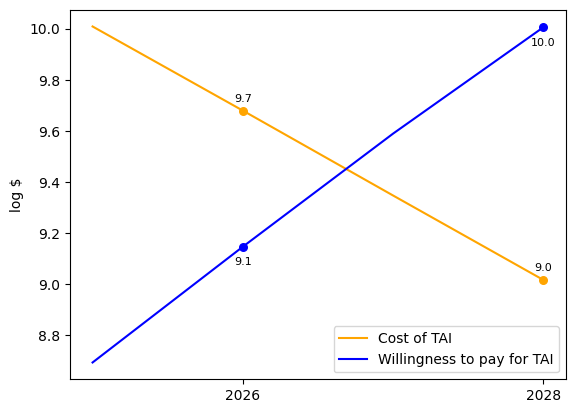

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 30.2 log FLOP (~1.6 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~571.5 quadrillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 20.2 log FLOP (~164.8 quintillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~589.9 million).
* This doubles every 0.5 year to a max of 0.035928% of GDP (initially ~9.1 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 30.2 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 8.7 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 29.8 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.2 (buys 27.1 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 29.4 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 9.6 (buys 27.6 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 29.1 logFLOP which cos

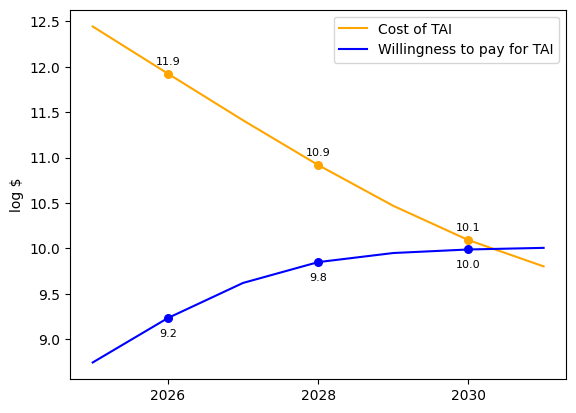

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.2 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~198.4 million).
* This doubles every 0.9 year to a max of 0.139526% of GDP (initially ~34.8 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 8.3 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 27.3 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.6 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 10 years 

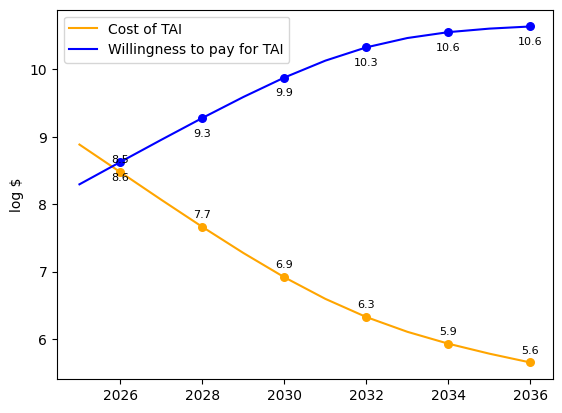

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 37.9 log FLOP (~79.4 thousand decillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 19.5 log FLOP (~28.8 quintillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~612.0 million).
* This doubles every 2.7 year to a max of 0.080906% of GDP (initially ~20.4 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 37.9 logFLOP which costs 19.9 log 2025$USD to buy vs. WTP at 8.8 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 37.8 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 37.6 logFLOP which costs 19.4 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.5 2025-log-eFLOP)
2028 - TAI takes 37.5 logFLOP 

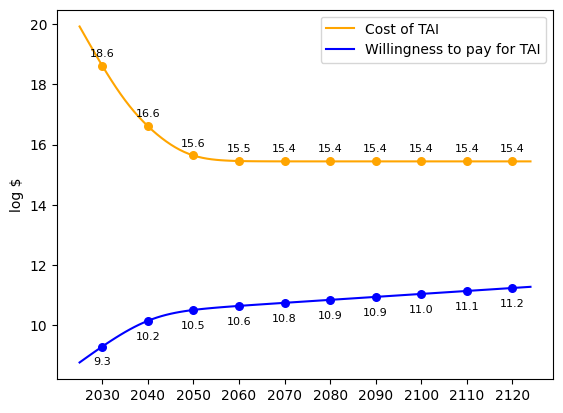

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 42.5 log FLOP (~3.2 billion decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.2 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~9.1 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.3 billion).
* This doubles every 2.1 year to a max of 0.022857% of GDP (initially ~5.7 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 42.5 logFLOP which costs 23.4 log 2025$USD to buy vs. WTP at 9.2 (buys 28.3 log FLOP or 28.3 2025-log-eFLOP)
2026 - TAI takes 42.2 logFLOP which costs 23.0 log 2025$USD to buy vs. WTP at 9.3 (buys 28.5 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 42.0 logFLOP which costs 22.7 log 2025$USD to buy vs. WTP at 9.4 (buys 28.7 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 41.7 logFLOP which 

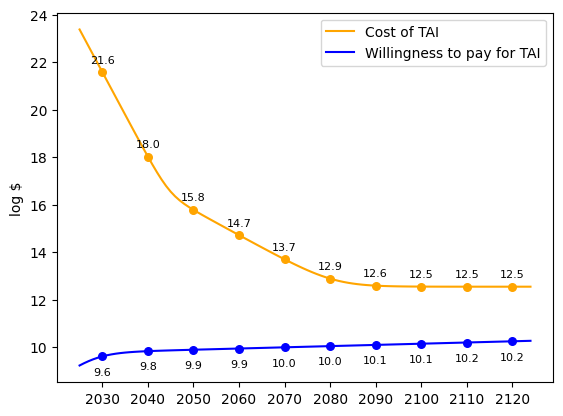

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 25.1 log FLOP (~12.6 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.7 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.7 billion).
* This doubles every 0.7 year to a max of 0.080886% of GDP (initially ~20.3 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 25.1 logFLOP which costs 7.0 log 2025$USD to buy vs. WTP at 9.4 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 6 years)

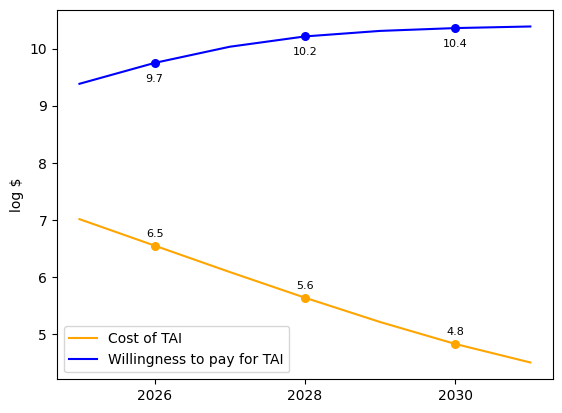

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 29.9 log FLOP (~794.3 octillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~958.9 quadrillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~914.9 quintillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 1.2 year to a max of 0.011107% of GDP (initially ~2.8 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 29.9 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.0 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 29.8 logFLOP which costs 11.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 29.7 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 9.2 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 29.5 logFLOP which co

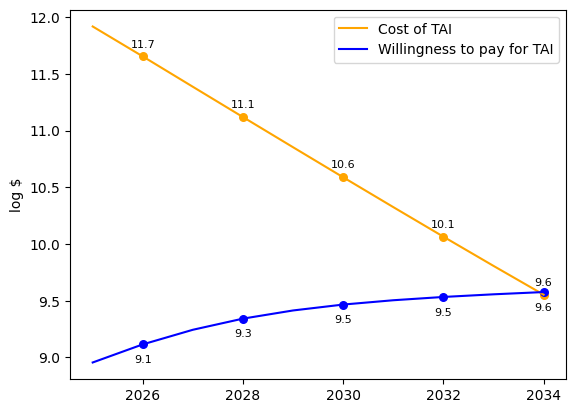

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 36.9 log FLOP (~7.9 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~804.5 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~499.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~951.4 million).
* This doubles every 0.4 year to a max of 0.077627% of GDP (initially ~19.6 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 36.9 logFLOP which costs 19.0 log 2025$USD to buy vs. WTP at 9.0 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 36.5 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 9.6 (buys 27.6 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 36.2 logFLOP which costs 18.0 log 2025$USD to buy vs. WTP at 10.1 (buys 28.2 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 35.8 logFLOP

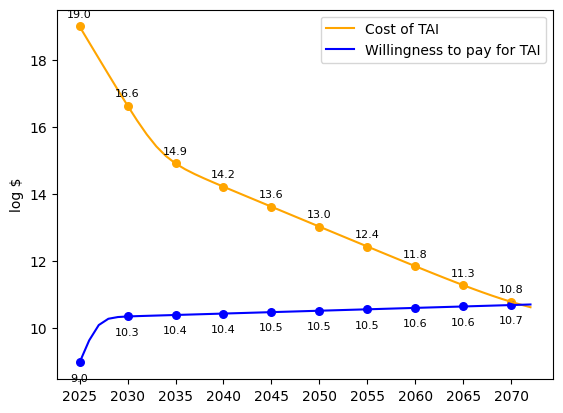

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 28.3 log FLOP (~20.0 octillion) for transformative capabilities.
* Every 3.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.2 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8.2 septillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~5.4 billion).
* This doubles every 0.7 year to a max of 0.150265% of GDP (initially ~37.5 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 28.3 logFLOP which costs 9.6 log 2025$USD to buy vs. WTP at 9.7 (buys 28.4 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 9 years (total delay 9 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 9 years)


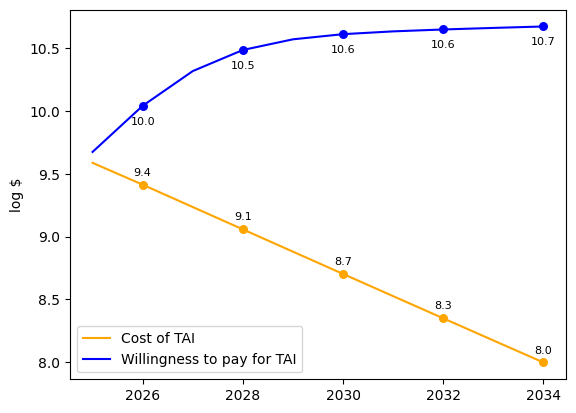

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 26.3 log FLOP (~199.5 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~559.6 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~438.5 quintillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~146.7 million).
* This doubles every 1.4 year to a max of 0.000823% of GDP (initially ~207.5 million 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 26.3 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 7.9 (buys 25.7 log FLOP or 25.7 2025-log-eFLOP)
2026 - TAI takes 26.0 logFLOP which costs 8.1 log 2025$USD to buy vs. WTP at 8.1 (buys 25.9 log FLOP or 26.3 2025-log-eFLOP)
2027 - TAI takes 25.6 logFLOP which costs 7.6 log 2025$USD to buy vs. WTP at 8.1 (buys 26.2 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0

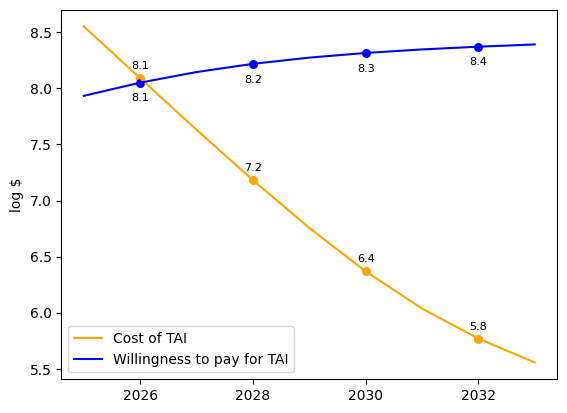

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 46.1 log FLOP (~12.6 trillion decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 6 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~603.9 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~115.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~315.2 million).
* This doubles every 0.8 year to a max of 0.394887% of GDP (initially ~98.7 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 46.1 logFLOP which costs 28.3 log 2025$USD to buy vs. WTP at 8.5 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
2026 - TAI takes 45.8 logFLOP which costs 27.9 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 45.6 logFLOP which costs 27.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.3 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 45.3 logFLO

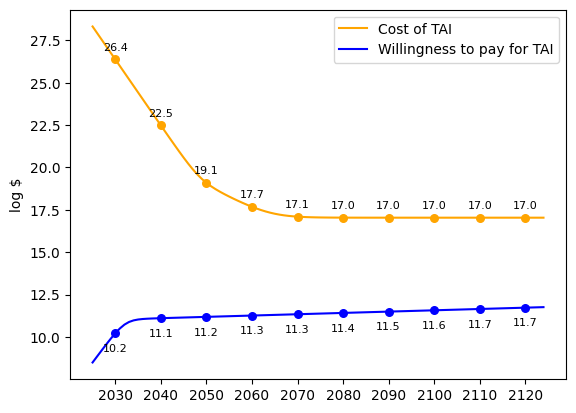

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 35.3 log FLOP (~199.5 decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~457.1 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~96.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~489.5 million).
* This doubles every 1.4 year to a max of 0.08303% of GDP (initially ~21.0 billion 2025$USD).
* GDP grows at a rate of 1.008x per year.
---
2025 - TAI takes 35.3 logFLOP which costs 17.6 log 2025$USD to buy vs. WTP at 8.7 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
2026 - TAI takes 35.0 logFLOP which costs 17.2 log 2025$USD to buy vs. WTP at 8.9 (buys 26.7 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 34.7 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.0 log FLOP or 27.6 2025-log-eFLOP)
2028 - TAI takes 34.5 logFLOP which co

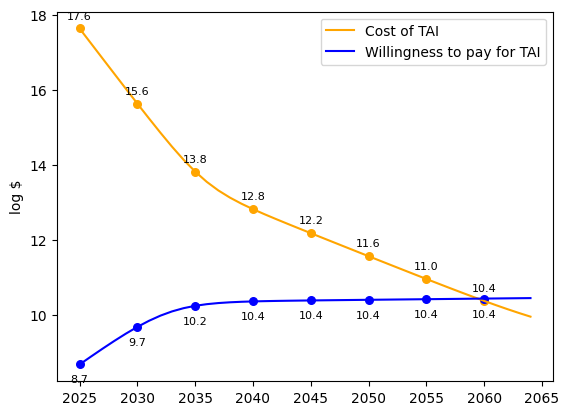

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 32.2 log FLOP (~158.5 nonillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~761.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~2.8 billion).
* This doubles every 0.8 year to a max of 0.039532% of GDP (initially ~9.9 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 32.2 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.3 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 31.6 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.6 (buys 28.1 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 31.0 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 9.8 (buys 28.5 log FLOP or 29.6 2025-log-eFLOP)
2028 - TAI takes 30.6 logFLOP which costs

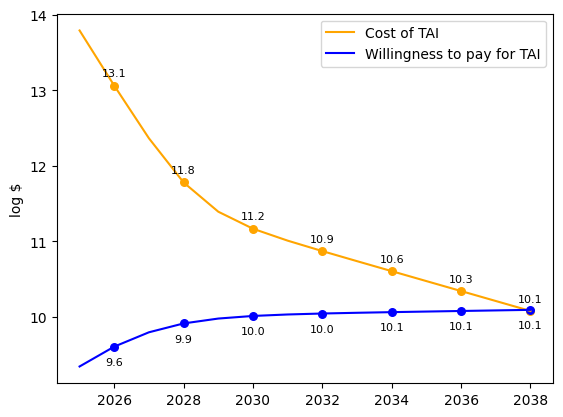

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 45.5 log FLOP (~3.2 trillion decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~812.7 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.6 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~245.1 million).
* This doubles every 1.1 year to a max of 0.004277% of GDP (initially ~1.1 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 45.5 logFLOP which costs 27.6 log 2025$USD to buy vs. WTP at 8.3 (buys 26.2 log FLOP or 26.2 2025-log-eFLOP)
2026 - TAI takes 45.1 logFLOP which costs 27.0 log 2025$USD to buy vs. WTP at 8.5 (buys 26.5 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 44.6 logFLOP which costs 26.5 log 2025$USD to buy vs. WTP at 8.7 (buys 26.8 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 44.2 logFLOP wh

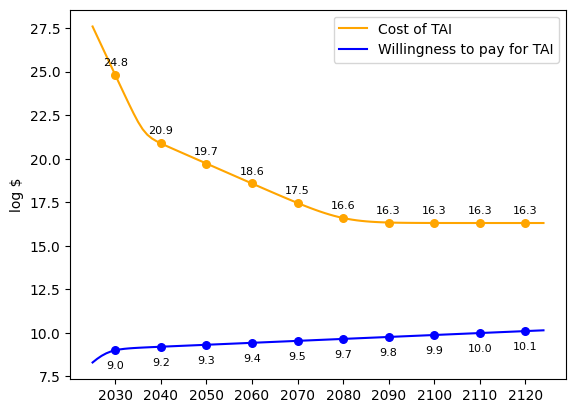

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 30.1 log FLOP (~1.3 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.4 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~351.8 million).
* This doubles every 0.6 year to a max of 0.012077% of GDP (initially ~3.0 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 30.1 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 8.5 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 29.9 logFLOP which costs 10.8 log 2025$USD to buy vs. WTP at 8.9 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 29.7 logFLOP which costs 10.4 log 2025$USD to buy vs. WTP at 9.2 (buys 28.5 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 29.4 logFLOP which costs 1

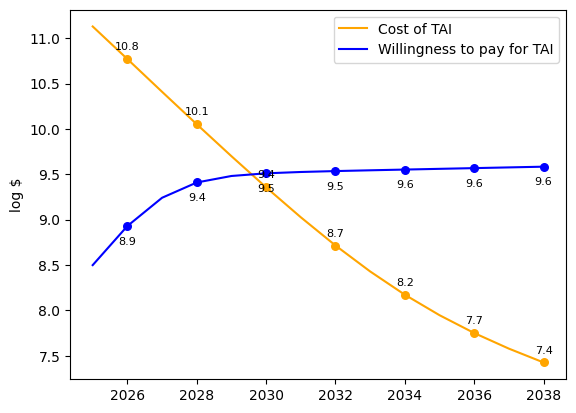

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 43.4 log FLOP (~25.1 billion decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.7 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~306.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 0.9 year to a max of 0.022604% of GDP (initially ~5.7 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 43.4 logFLOP which costs 24.4 log 2025$USD to buy vs. WTP at 9.1 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 42.6 logFLOP which costs 23.5 log 2025$USD to buy vs. WTP at 9.3 (buys 28.4 log FLOP or 29.2 2025-log-eFLOP)
2027 - TAI takes 41.8 logFLOP which costs 22.6 log 2025$USD to buy vs. WTP at 9.5 (buys 28.7 log FLOP or 30.3 2025-log-eFLOP)
2028 - TAI takes 41.0 logFLOP whi

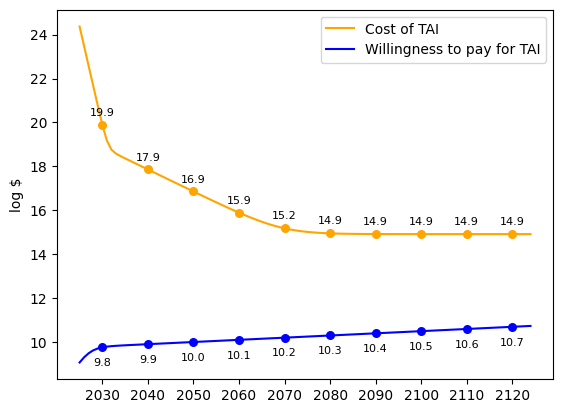

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 40.8 log FLOP (~63.1 million decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.5 log FLOP (~308.3 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~139.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~746.3 million).
* This doubles every 2.4 year to a max of 0.049133% of GDP (initially ~12.3 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 40.8 logFLOP which costs 23.3 log 2025$USD to buy vs. WTP at 8.8 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
2026 - TAI takes 40.3 logFLOP which costs 22.7 log 2025$USD to buy vs. WTP at 9.0 (buys 26.6 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 39.8 logFLOP which costs 22.1 log 2025$USD to buy vs. WTP at 9.1 (buys 26.8 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 39.3 logFLOP

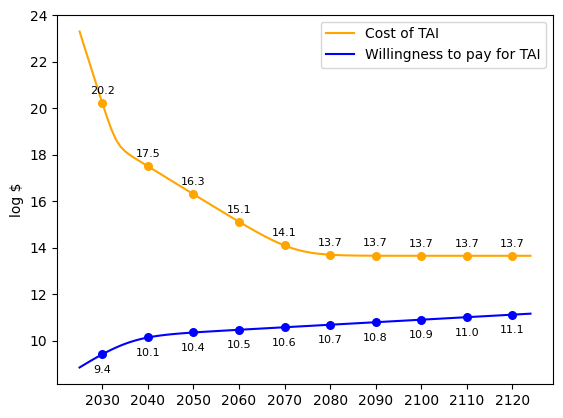

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 33.6 log FLOP (~4.0 decillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.1 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~1.9 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.1 billion).
* This doubles every 0.9 year to a max of 0.042586% of GDP (initially ~10.6 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 33.6 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 33.5 logFLOP which costs 15.3 log 2025$USD to buy vs. WTP at 9.3 (buys 27.4 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 33.4 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 9.6 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 33.3 logFLOP which costs 14

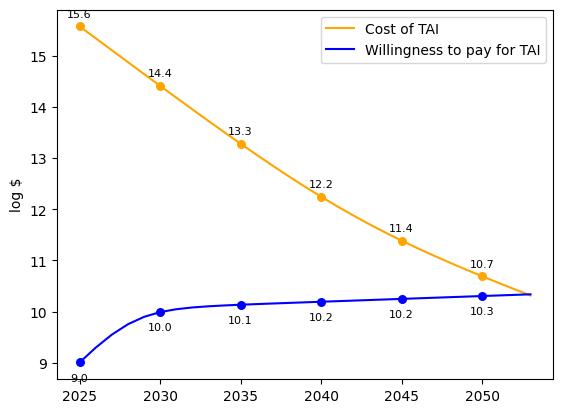

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 33.6 log FLOP (~4.0 decillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.6 log FLOP (~405.4 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 0.7 year to a max of 0.177423% of GDP (initially ~44.5 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 33.6 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 9.2 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 33.5 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 9.6 (buys 27.3 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 33.4 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 9.9 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 33.2 logFLOP which costs 

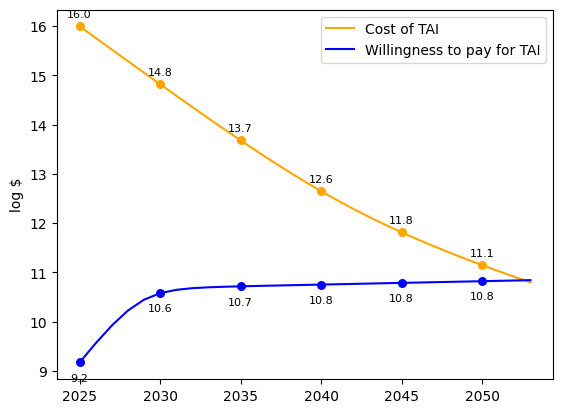

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~712.1 quintillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~338.5 million).
* This doubles every 0.6 year to a max of 0.008967% of GDP (initially ~2.3 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 34.0 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.5 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 33.7 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 8.9 (buys 27.4 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 33.4 logFLOP which costs 14.8 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 33.1 logFLOP which cos

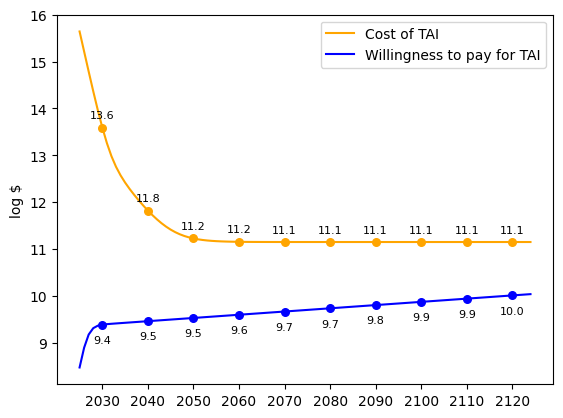

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 29.5 log FLOP (~316.2 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.7 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~870.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~692.6 million).
* This doubles every 1.6 year to a max of 0.003782% of GDP (initially ~956.2 million 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 29.5 logFLOP which costs 10.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 29.2 logFLOP which costs 10.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 28.9 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 28.7 logFLOP which co

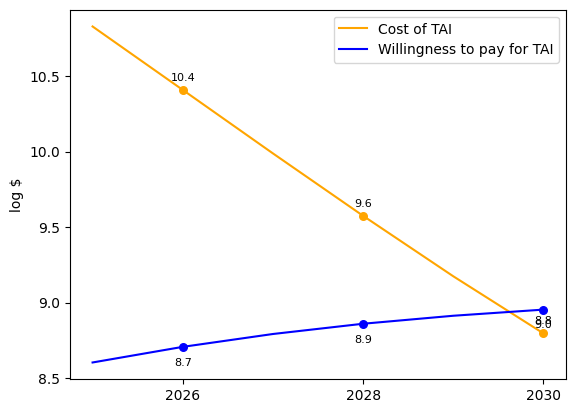

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 36.7 log FLOP (~5.0 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~96.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~726.7 million).
* This doubles every 0.9 year to a max of 0.033912% of GDP (initially ~8.5 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 36.7 logFLOP which costs 18.0 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 36.4 logFLOP which costs 17.6 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 36.2 logFLOP which costs 17.2 log 2025$USD to buy vs. WTP at 9.4 (buys 28.3 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 35.9 logFLOP whi

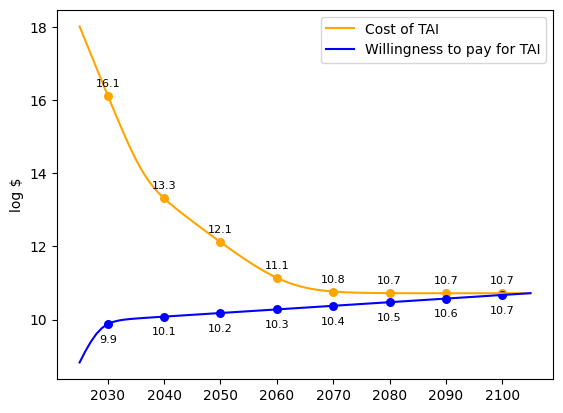

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 31.5 log FLOP (~31.6 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~615.1 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~26.8 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~785.3 million).
* This doubles every 0.4 year to a max of 0.275925% of GDP (initially ~69.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 31.5 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 8.9 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 31.2 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 9.7 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 30.9 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 10.3 (buys 28.4 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 30.7 logFLOP which c

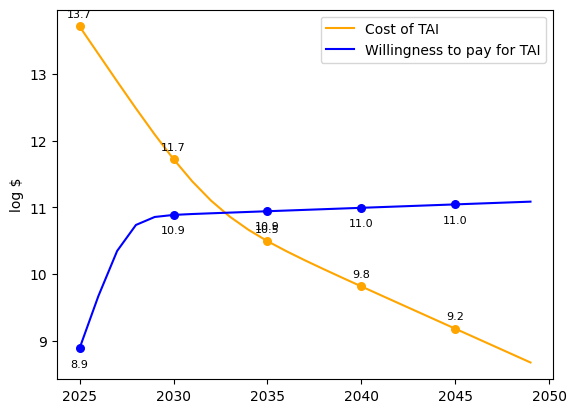

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 39.7 log FLOP (~5.0 million decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.7 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~5.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.8 billion).
* This doubles every 0.8 year to a max of 0.065815% of GDP (initially ~16.5 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 39.7 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 9.2 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 39.5 logFLOP which costs 20.5 log 2025$USD to buy vs. WTP at 9.5 (buys 28.5 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 39.3 logFLOP which costs 20.2 log 2025$USD to buy vs. WTP at 9.8 (buys 28.9 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 39.0 logFLOP which 

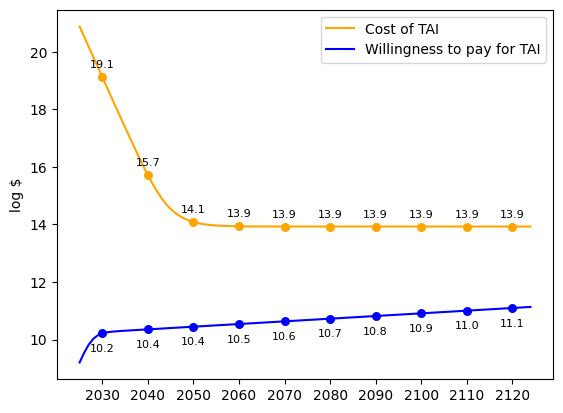

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 38.7 log FLOP (~501.2 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4.0 log reductions possible.
* FLOP start at a cost of 17.5 log FLOP (~319.7 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~9.6 septillion) per 2025$USD.
* We are initially willing to pay 8.0 log 2025$USD (~95.1 million).
* This doubles every 1.8 year to a max of 0.000409% of GDP (initially ~102.8 million 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 38.7 logFLOP which costs 21.2 log 2025$USD to buy vs. WTP at 7.7 (buys 25.2 log FLOP or 25.2 2025-log-eFLOP)
2026 - TAI takes 38.4 logFLOP which costs 20.8 log 2025$USD to buy vs. WTP at 7.8 (buys 25.4 log FLOP or 25.7 2025-log-eFLOP)
2027 - TAI takes 38.1 logFLOP which costs 20.3 log 2025$USD to buy vs. WTP at 7.9 (buys 25.6 log FLOP or 26.2 2025-log-eFLOP)
2028 - TAI takes 37.7 logFL

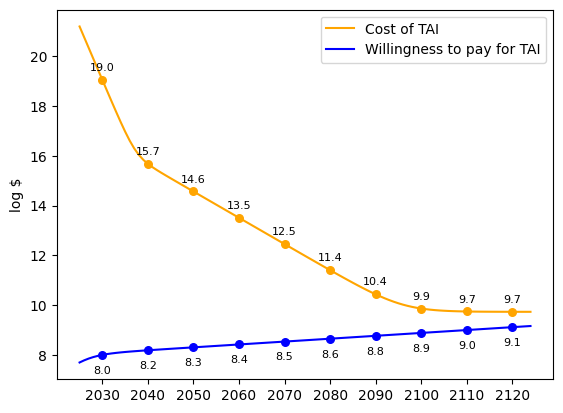

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 37.4 log FLOP (~25.1 thousand decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~472.6 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~352.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~962.2 million).
* This doubles every 1.9 year to a max of 0.101398% of GDP (initially ~25.4 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 37.4 logFLOP which costs 19.7 log 2025$USD to buy vs. WTP at 9.0 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 36.8 logFLOP which costs 19.0 log 2025$USD to buy vs. WTP at 9.1 (buys 26.9 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 36.2 logFLOP which costs 18.3 log 2025$USD to buy vs. WTP at 9.3 (buys 27.2 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 35.6 logFLO

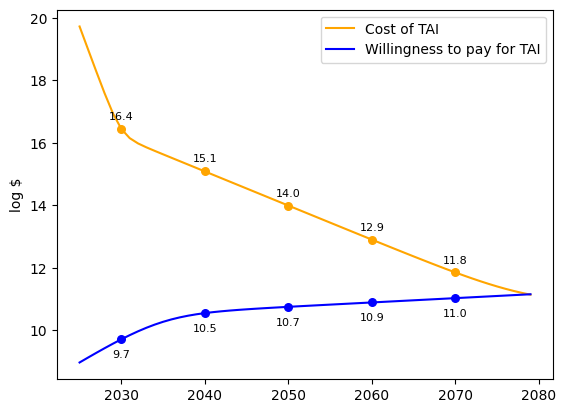

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 40.5 log FLOP (~31.6 million decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.9 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~597.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~496.8 million).
* This doubles every 0.8 year to a max of 0.002632% of GDP (initially ~661.5 million 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 40.5 logFLOP which costs 21.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 40.1 logFLOP which costs 21.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 39.7 logFLOP which costs 20.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.9 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 39.3 logFLOP 

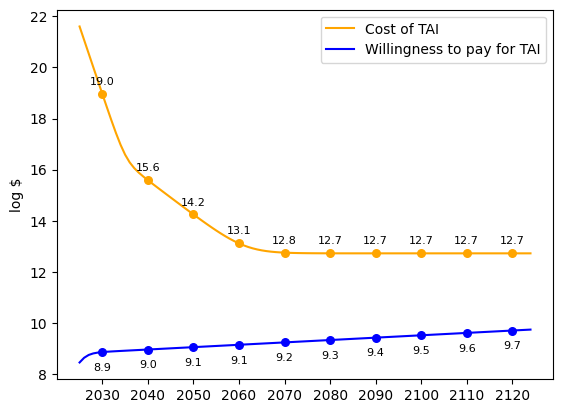

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 38.7 log FLOP (~501.2 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~659.1 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.2 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 1.3 year to a max of 0.024281% of GDP (initially ~6.1 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 38.7 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 9.0 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 38.5 logFLOP which costs 20.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.1 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 38.2 logFLOP which costs 20.2 log 2025$USD to buy vs. WTP at 9.4 (buys 27.4 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 38.0 logFLOP whi

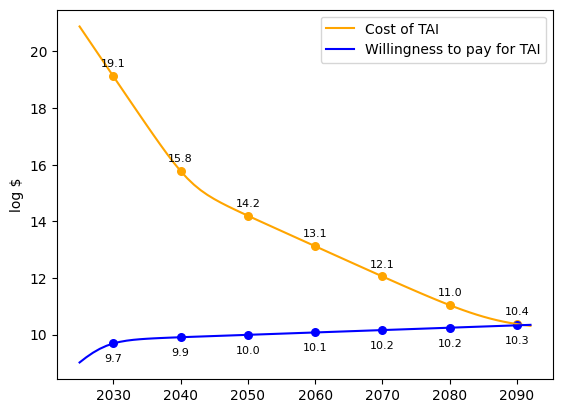

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 31.5 log FLOP (~31.6 nonillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~680.0 quadrillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~42.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~765.7 million).
* This doubles every 1.1 year to a max of 0.084711% of GDP (initially ~21.3 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 31.5 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 8.9 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 31.0 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 9.1 (buys 27.1 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 30.5 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 9.4 (buys 27.5 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 30.1 logFLOP which co

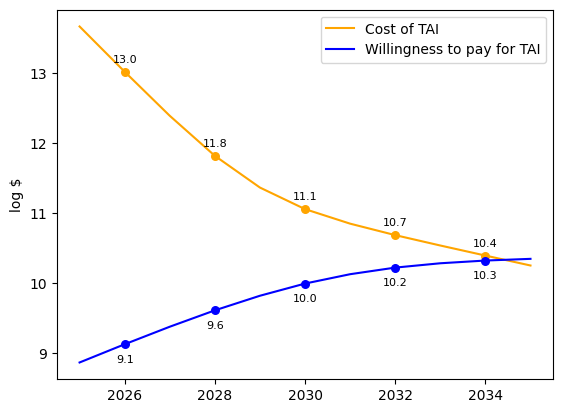

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 29.1 log FLOP (~125.9 octillion) for transformative capabilities.
* Every 2.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~449.6 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~55.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~3.6 billion).
* This doubles every 1.5 year to a max of 0.051804% of GDP (initially ~12.9 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 29.1 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 9.5 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 29.0 logFLOP which costs 11.2 log 2025$USD to buy vs. WTP at 9.6 (buys 27.4 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 28.9 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 9.7 (buys 27.7 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 28.8 logFLOP which cos

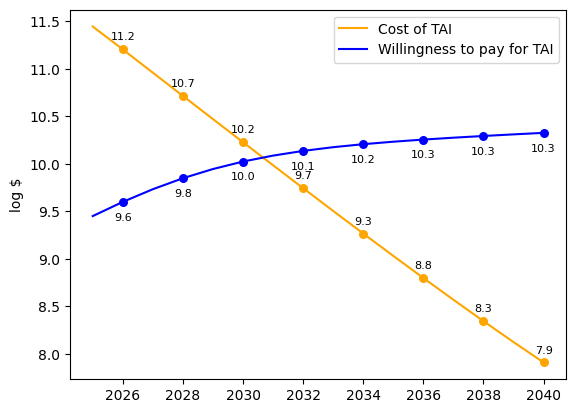

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 31.2 log FLOP (~15.8 nonillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~465.9 quadrillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~71.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.1 billion).
* This doubles every 0.4 year to a max of 0.051221% of GDP (initially ~12.9 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 31.2 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 9.0 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 30.6 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 9.6 (buys 27.4 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 30.1 logFLOP which costs 12.2 log 2025$USD to buy vs. WTP at 10.0 (buys 28.0 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 29.7 logFLOP which cos

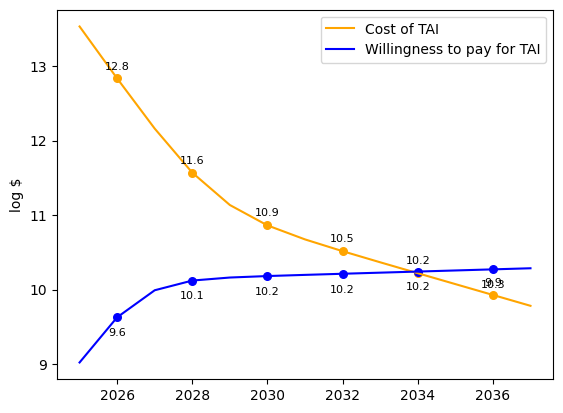

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 32.9 log FLOP (~794.3 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~657.8 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.4 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.6 billion).
* This doubles every 0.9 year to a max of 0.054738% of GDP (initially ~13.7 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 32.9 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 9.3 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 32.6 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 9.6 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 32.3 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 9.8 (buys 27.9 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 32.0 logFLOP which cost

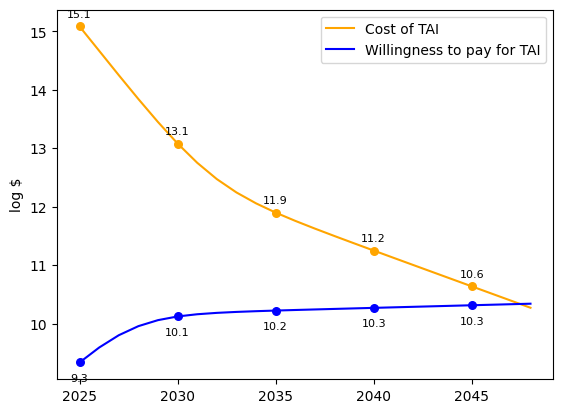

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 27.5 log FLOP (~3.2 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.4 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~693.5 million).
* This doubles every 0.7 year to a max of 0.006136% of GDP (initially ~1.5 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 27.5 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 27.2 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 8 years (t

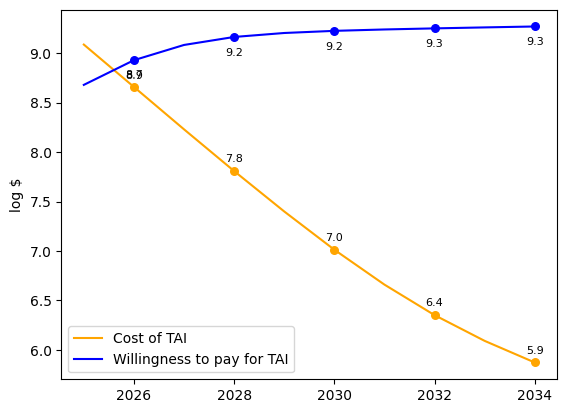

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 29.1 log FLOP (~125.9 octillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.6 log FLOP (~42.6 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~4.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~305.0 million).
* This doubles every 1.1 year to a max of 0.034367% of GDP (initially ~8.6 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 29.1 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.5 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 29.0 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 8.7 (buys 28.5 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 28.8 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 9.0 (buys 28.9 log FLOP or 29.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 -

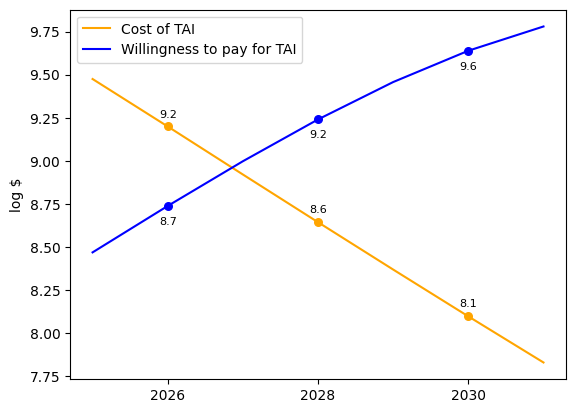

In [16]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [17]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-09-12 21:05:36.881058
